In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install bagpy --quiet

import os
import gc
import ast
import math
import h5py
import yaml
import time
import torch
import bagpy
import rosbag
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from bagpy import bagreader

%matplotlib inline
gc.collect()

SRC = "/content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/"
SRC_ESIM = "/content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/esim/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def unzip_npz(src):
  data = np.load(src, allow_pickle = True)
  lst = data.files
  for item in lst:
    print(item)
    #print(data[item])

def unzip(src, dest):
  t_file = tarfile.open(src) # Open file
  t_file.extractall(dest) # Extract file  
  t_file.close()

def parse_events(event):
  x = []
  y = []
  secs = []
  nsecs = []
  polarity = []
  tokens = event.splitlines();
  for t in tokens:
    if 'x: ' in t:
      temp_t = t
      if '[' in t: # Handle special case for beginning of array
        temp_t = temp_t.replace('[', '')
      elif 'polarity: False, ' in temp_t:
        temp_t = temp_t.replace('polarity: False, ', '') # Handle special case for polarity and x values being on same line
      elif 'polarity: True, ' in temp_t:
        temp_t = temp_t.replace('polarity: True, ', '')
      temp_t = temp_t.replace('x: ', '')
      x.append(int(temp_t))
    elif 'y: ' in t and t[0] == 'y': # Do not get lines with polarity, only y
      temp_t = t
      temp_t = temp_t.replace('y: ', '')
      y.append(int(temp_t))
    elif 'secs: ' in t and 'n' not in t:
      temp_t = t
      temp_t = temp_t.replace('secs: ', '')
      secs.append(int(temp_t))
    elif 'nsecs: ' in t:
      temp_t = t
      temp_t = temp_t.replace('nsecs: ', '')
      nsecs.append(int(temp_t))
    elif 'polarity: ' in t:
      temp_t = t
      if 'True' in temp_t:
        polarity.append(True)
      elif 'False' in temp_t:
        polarity.append(False)    
  return x, y, secs, nsecs, polarity

def unpack_rosbag(rosbag_path, topic_type):
  bag_reader_obj = bagreader(rosbag_path)
  # Output the topic table for reference
  print(bag_reader_obj.topic_table)
  # Decode messages by topic - run if you do not have the csv files saved already
  print("Creating .csv file.")
  topic = bag_reader_obj.message_by_topic(topic_type)
  print("File saved: {}".format(topic))
  # Create dataframe from the topic
  df = pd.read_csv(topic)
  return topic, df

def convert_rosbag_timestamps(df, time_series, ns_time_series):
  new_times = []
  init_t = df['header.stamp.secs'][0]
  init_ns = df['header.stamp.nsecs'][0]
  for time_, time_ns in zip(time_series, ns_time_series):
    new_time = (time_ - init_t) + ((time_ns - init_ns) / 1e9)
    new_times.append(new_time)
  # Append the series to the dataframe
  df['New Time'] = np.array(new_times).tolist()

def create_velocity_gt(df):
  ptr = 0
  time = []
  x = []
  y = []
  z = []
  while ptr < len(df) - 1:
    delta_time = df['New Time'][ptr + 1] - df['New Time'][ptr]
    timestamp = (df['New Time'][ptr + 1] + df['New Time'][ptr]) / 2
    time.append(timestamp)
    delta_x = df['transform.translation.x'][ptr + 1] - df['transform.translation.x'][ptr]
    delta_y = df['transform.translation.y'][ptr + 1] - df['transform.translation.y'][ptr]
    delta_z = df['transform.translation.z'][ptr + 1] - df['transform.translation.z'][ptr]
    result = calculate_velocity(delta_time, delta_x, delta_y, delta_z)
    x.append(result[0])
    y.append(result[1])
    z.append(result[2])
    ptr += 1
  d = {'Time': time, 'Vel_x': x, 'Vel_y': y, 'Vel_z': z}
  gt_df = pd.DataFrame.from_dict(d)
  return gt_df

def calculate_velocity(delta_time, delta_x, delta_y, delta_z):
  result = []
  x_component = (delta_x / delta_time)
  y_component = (delta_y / delta_time)
  z_component = (delta_z / delta_time)
  result.append(x_component)
  result.append(y_component)
  result.append(z_component)
  return result

def remove_rows_with_empty_events(csv_file):
  df = pd.read_csv(csv_file, index_col = 0)
  print("Length of original dataframe: ", len(df))
  temp_df = df.dropna(how = 'any')
  print("Length of dataframe after dropping NA values: ", len(temp_df))
  # Drop the time and other extra columns column
  temp_df = temp_df.drop('Time', axis = 1)
  # Drop the row if there are no events - convert string representation to list
  for index, e in temp_df.iterrows():
    list_rep_e = convert_to_list(e['Events']) # Event data here in tuple
    if len(list_rep_e) < 1:
      temp_df.drop(index, inplace = True) # Drop by index
  print("Length of dataframe after dropping empty events: ", len(temp_df))
  print("Shape of new dataframe: ", temp_df.shape)
  return temp_df.reset_index()

def convert_to_list(string_representation):
  list_ = ast.literal_eval(string_representation)
  return list_

def populate_gt_df(gt_df, event_df, start_flag):
  ptr = 0
  event_array_to_add = []
  while ptr < len(gt_df) - 1:
    if start_flag:
      if ptr == 0:
        events = align_events_with_gt(event_df, 0.0, gt_df['Time'][ptr])
      else:
        events = align_events_with_gt(event_df, gt_df['Time'][ptr], gt_df['Time'][ptr + 1])
    else:
      events = align_events_with_gt(event_df, gt_df['Time'][ptr], gt_df['Time'][ptr + 1])
    event_array_to_add.append(events) # List of group of events, or list of lists of lists
    print("Processed event group " + str(ptr) + " / " + str(len(gt_df)) + ".")
    ptr += 1
  # Concatenate to ground truth dataframe
  gt_df['Events'] = pd.Series(event_array_to_add)
  return gt_df

def align_events_with_gt(event_df, start_time, end_time):
  event_arrays = []
  event_group = event_df.loc[event_df['t'].between(start_time, end_time)]
  for e in tqdm(event_group.iterrows()): # e is a tuple
    event = [] # Represents a single event, list of t, x, y, p
    event.append(e[1][0]) # t
    event.append(e[1][1]) # x
    event.append(e[1][2]) # y
    event.append(e[1][3]) # p
    event_arrays.append(event) # All events within this time range, list of lists
  return event_arrays

In [ ]:
topic_sliding, df_sliding = unpack_rosbag(SRC + '2022-03-11-14-02-28_box_floor.bag', '/vicon/box/box')
convert_rosbag_timestamps(df_sliding, df_sliding['header.stamp.secs'], df_sliding["header.stamp.nsecs"])
df_sliding.head()

[INFO]  Successfully created the data folder /content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/2022-03-11-14-02-28_box_floor.
           Topics                            Types  Message Count    Frequency
0    /diagnostics  diagnostic_msgs/DiagnosticArray            107     0.984022
1         /rosout                rosgraph_msgs/Log              8  1985.939394
2     /rosout_agg                rosgraph_msgs/Log              2     0.600068
3             /tf               tf2_msgs/TFMessage           6458    59.792211
4  /vicon/box/box   geometry_msgs/TransformStamped           6238    59.799031
5  /vicon/markers             vicon_bridge/Markers           6457    59.789654
Creating .csv file.
File saved: /content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/2022-03-11-14-02-28_box_floor/vicon-box-box.csv


,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,transform.translation.x,transform.translation.y,transform.translation.z,transform.rotation.x,transform.rotation.y,transform.rotation.z,transform.rotation.w,New Time
0,1.647025e+09,38296,1647025348,730186569,/vicon/world,vicon/box/box,0.354663,0.462745,0.091698,0.009525,0.005766,0.972634,0.232074,0.000000
1,1.647025e+09,38297,1647025348,746947332,/vicon/world,vicon/box/box,0.354676,0.462746,0.091630,0.009436,0.005692,0.972620,0.232142,0.016761
2,1.647025e+09,38298,1647025348,763498506,/vicon/world,vicon/box/box,0.354672,0.462749,0.091686,0.009507,0.005739,0.972637,0.232063,0.033312
3,1.647025e+09,38299,1647025348,780239063,/vicon/world,vicon/box/box,0.354669,0.462745,0.091635,0.009465,0.005667,0.972618,0.232147,0.050052
4,1.647025e+09,38300,1647025348,796857081,/vicon/world,vicon/box/box,0.354668,0.462749,0.091697,0.009538,0.005770,0.972634,0.232073,0.066671


In [ ]:
df_sliding_mod = df_sliding[df_sliding['New Time'].between(12, 48)]

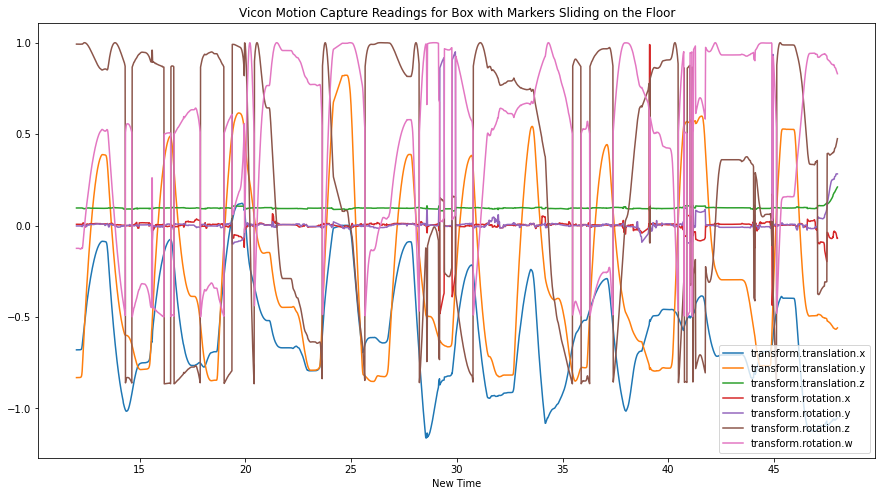

In [ ]:
df_sliding_mod.plot(x = 'New Time', 
                  y = ['transform.translation.x',
                       'transform.translation.y',
                       'transform.translation.z',
                       'transform.rotation.x',
                       'transform.rotation.y',
                       'transform.rotation.z',
                       'transform.rotation.w'], 
               title = 'Vicon Motion Capture Readings for Box with Markers Sliding on the Floor',
               figsize = (15, 8))

In [ ]:
df_sliding_mod = df_sliding_mod.reset_index(drop = True)
gt_sliding = create_velocity_gt(df_sliding_mod)
gt_sliding.head()

,Time,Vel_x,Vel_y,Vel_z
0,12.024709,0.000651,0.001147,0.005629
1,12.041345,-0.000780,-0.000743,-0.004968
2,12.058058,0.000424,0.000512,0.005870
3,12.074762,-0.000791,-0.001120,-0.007484
4,12.091423,0.000872,-0.000157,0.006826


In [ ]:
event_sliding_df = pd.read_csv(SRC + 'out.txt', sep = " ", skiprows = 1, index_col = False, names = ['t', 'x', 'y', 'p'])

In [ ]:
event_sliding_df['t'] = event_sliding_df['t'] + 12
event_sliding_df.head()

,t,x,y,p
0,12.033219,86,38,1
1,12.033234,109,81,1
2,12.095998,88,23,1
3,12.098062,83,19,1
4,12.193859,117,105,1


In [ ]:
event_sliding_df.tail()

,t,x,y,p
19957640,47.792836,376,186,0
19957641,47.833592,1728,949,1
19957642,47.843583,1402,700,1
19957643,47.895392,457,1041,1
19957644,47.917753,314,672,1


In [ ]:
gt_sliding_with_events = populate_gt_df(gt_sliding, event_sliding_df, False)
gt_sliding_with_events.head()

2it [00:00, 3560.53it/s]


Processed event group 0 / 2118.


0it [00:00, ?it/s]


Processed event group 1 / 2118.


0it [00:00, ?it/s]


Processed event group 2 / 2118.


0it [00:00, ?it/s]


Processed event group 3 / 2118.


2it [00:00, 4175.51it/s]


Processed event group 4 / 2118.


0it [00:00, ?it/s]


Processed event group 5 / 2118.


0it [00:00, ?it/s]


Processed event group 6 / 2118.


0it [00:00, ?it/s]


Processed event group 7 / 2118.


0it [00:00, ?it/s]


Processed event group 8 / 2118.


0it [00:00, ?it/s]


Processed event group 9 / 2118.


3it [00:00, 4262.50it/s]


Processed event group 10 / 2118.


0it [00:00, ?it/s]


Processed event group 11 / 2118.


2it [00:00, 3807.81it/s]


Processed event group 12 / 2118.


0it [00:00, ?it/s]


Processed event group 13 / 2118.


0it [00:00, ?it/s]


Processed event group 14 / 2118.


0it [00:00, ?it/s]


Processed event group 15 / 2118.


4it [00:00, 5733.84it/s]


Processed event group 16 / 2118.


512it [00:00, 19414.39it/s]


Processed event group 17 / 2118.


1327it [00:00, 22921.11it/s]


Processed event group 18 / 2118.


0it [00:00, ?it/s]


Processed event group 19 / 2118.


0it [00:00, ?it/s]


Processed event group 20 / 2118.


1it [00:00, 1656.52it/s]


Processed event group 21 / 2118.


7it [00:00, 3485.71it/s]


Processed event group 22 / 2118.


25it [00:00, 16820.28it/s]


Processed event group 23 / 2118.


21it [00:00, 16408.42it/s]


Processed event group 24 / 2118.


0it [00:00, ?it/s]


Processed event group 25 / 2118.


1it [00:00, 1493.70it/s]


Processed event group 26 / 2118.


5it [00:00, 7784.53it/s]


Processed event group 27 / 2118.


20it [00:00, 12372.58it/s]


Processed event group 28 / 2118.


59it [00:00, 20060.31it/s]


Processed event group 29 / 2118.


95it [00:00, 20550.77it/s]


Processed event group 30 / 2118.


16it [00:00, 13720.89it/s]


Processed event group 31 / 2118.


35it [00:00, 17270.66it/s]


Processed event group 32 / 2118.


16it [00:00, 10881.93it/s]


Processed event group 33 / 2118.


9it [00:00, 7987.46it/s]


Processed event group 34 / 2118.


1it [00:00, 2321.14it/s]


Processed event group 35 / 2118.


1it [00:00, 2387.20it/s]


Processed event group 36 / 2118.


7it [00:00, 8732.94it/s]


Processed event group 37 / 2118.


13it [00:00, 12211.86it/s]


Processed event group 38 / 2118.


2714it [00:00, 23168.47it/s]


Processed event group 39 / 2118.


3509it [00:00, 22404.85it/s]


Processed event group 40 / 2118.


45714it [00:01, 22907.01it/s]


Processed event group 41 / 2118.


28350it [00:01, 21389.73it/s]


Processed event group 42 / 2118.


49562it [00:02, 23176.36it/s]


Processed event group 43 / 2118.


33882it [00:01, 21816.45it/s]


Processed event group 44 / 2118.


41940it [00:01, 23327.45it/s]


Processed event group 45 / 2118.


33677it [00:01, 23511.29it/s]


Processed event group 46 / 2118.


39776it [00:01, 21924.68it/s]


Processed event group 47 / 2118.


33036it [00:01, 22986.96it/s]


Processed event group 48 / 2118.


37199it [00:01, 23001.09it/s]


Processed event group 49 / 2118.


31245it [00:01, 21439.65it/s]


Processed event group 50 / 2118.


36991it [00:01, 23211.55it/s]


Processed event group 51 / 2118.


30334it [00:01, 23271.04it/s]


Processed event group 52 / 2118.


36517it [00:01, 22979.60it/s]


Processed event group 53 / 2118.


28851it [00:01, 20663.31it/s]


Processed event group 54 / 2118.


35131it [00:01, 22699.44it/s]


Processed event group 55 / 2118.


28854it [00:01, 23187.11it/s]


Processed event group 56 / 2118.


33332it [00:01, 22650.51it/s]


Processed event group 57 / 2118.


26310it [00:01, 23067.07it/s]


Processed event group 58 / 2118.


31056it [00:01, 21233.82it/s]


Processed event group 59 / 2118.


24318it [00:01, 19079.37it/s]


Processed event group 60 / 2118.


28115it [00:01, 19731.80it/s]


Processed event group 61 / 2118.


22945it [00:01, 17128.49it/s]


Processed event group 62 / 2118.


26553it [00:01, 23105.39it/s]


Processed event group 63 / 2118.


21823it [00:00, 23190.52it/s]


Processed event group 64 / 2118.


24352it [00:01, 23350.52it/s]


Processed event group 65 / 2118.


20321it [00:00, 23414.09it/s]


Processed event group 66 / 2118.


23984it [00:01, 21203.66it/s]


Processed event group 67 / 2118.


19620it [00:00, 21547.04it/s]


Processed event group 68 / 2118.


23426it [00:01, 22453.81it/s]


Processed event group 69 / 2118.


19493it [00:01, 18537.80it/s]


Processed event group 70 / 2118.


21778it [00:01, 21267.93it/s]


Processed event group 71 / 2118.


18061it [00:00, 21335.85it/s]


Processed event group 72 / 2118.


20991it [00:00, 21970.52it/s]


Processed event group 73 / 2118.


16896it [00:00, 23605.11it/s]


Processed event group 74 / 2118.


18399it [00:00, 22768.44it/s]


Processed event group 75 / 2118.


15127it [00:00, 22470.38it/s]


Processed event group 76 / 2118.


15355it [00:00, 23662.36it/s]


Processed event group 77 / 2118.


12115it [00:00, 22954.24it/s]


Processed event group 78 / 2118.


13680it [00:00, 22907.20it/s]


Processed event group 79 / 2118.


10822it [00:00, 23099.60it/s]


Processed event group 80 / 2118.


11253it [00:00, 23514.66it/s]


Processed event group 81 / 2118.


9124it [00:00, 23495.15it/s]


Processed event group 82 / 2118.


9942it [00:00, 23658.71it/s]


Processed event group 83 / 2118.


8422it [00:00, 23704.95it/s]


Processed event group 84 / 2118.


8237it [00:00, 23462.28it/s]


Processed event group 85 / 2118.


7100it [00:00, 22704.72it/s]


Processed event group 86 / 2118.


3169it [00:00, 21305.01it/s]


Processed event group 87 / 2118.


2875it [00:00, 21148.91it/s]


Processed event group 88 / 2118.


272it [00:00, 20948.03it/s]


Processed event group 89 / 2118.


558it [00:00, 21502.14it/s]


Processed event group 90 / 2118.


945it [00:00, 23063.46it/s]


Processed event group 91 / 2118.


1221it [00:00, 23453.97it/s]


Processed event group 92 / 2118.


1379it [00:00, 21277.26it/s]


Processed event group 93 / 2118.


1331it [00:00, 21856.45it/s]


Processed event group 94 / 2118.


1127it [00:00, 22424.11it/s]


Processed event group 95 / 2118.


1368it [00:00, 22026.73it/s]


Processed event group 96 / 2118.


2660it [00:00, 23277.09it/s]


Processed event group 97 / 2118.


3192it [00:00, 23064.25it/s]


Processed event group 98 / 2118.


9703it [00:00, 23011.20it/s]


Processed event group 99 / 2118.


10197it [00:00, 22266.84it/s]


Processed event group 100 / 2118.


12570it [00:00, 16390.26it/s]


Processed event group 101 / 2118.


11905it [00:00, 23255.28it/s]


Processed event group 102 / 2118.


12211it [00:00, 23615.12it/s]


Processed event group 103 / 2118.


14840it [00:00, 22844.54it/s]


Processed event group 104 / 2118.


20285it [00:00, 23011.33it/s]


Processed event group 105 / 2118.


20222it [00:00, 23428.20it/s]


Processed event group 106 / 2118.


22448it [00:00, 22826.45it/s]


Processed event group 107 / 2118.


25418it [00:01, 23019.19it/s]


Processed event group 108 / 2118.


28709it [00:01, 22333.09it/s]


Processed event group 109 / 2118.


35748it [00:01, 23091.89it/s]


Processed event group 110 / 2118.


45921it [00:01, 23336.20it/s]


Processed event group 111 / 2118.


53944it [00:02, 23152.05it/s]


Processed event group 112 / 2118.


66910it [00:03, 21015.65it/s]


Processed event group 113 / 2118.


70844it [00:03, 23093.15it/s]


Processed event group 114 / 2118.


79361it [00:03, 23193.54it/s]


Processed event group 115 / 2118.


85729it [00:03, 22989.45it/s]


Processed event group 116 / 2118.


87752it [00:03, 23303.04it/s]


Processed event group 117 / 2118.


77796it [00:03, 21719.89it/s]


Processed event group 118 / 2118.


65156it [00:03, 20246.84it/s]


Processed event group 119 / 2118.


49752it [00:02, 23099.62it/s]


Processed event group 120 / 2118.


33415it [00:01, 23090.66it/s]


Processed event group 121 / 2118.


28810it [00:01, 23207.47it/s]


Processed event group 122 / 2118.


7944it [00:00, 23102.48it/s]


Processed event group 123 / 2118.


5749it [00:00, 22538.01it/s]


Processed event group 124 / 2118.


1921it [00:00, 23417.50it/s]


Processed event group 125 / 2118.


1450it [00:00, 22321.26it/s]


Processed event group 126 / 2118.


758it [00:00, 23144.61it/s]


Processed event group 127 / 2118.


527it [00:00, 22868.95it/s]


Processed event group 128 / 2118.


135it [00:00, 17762.44it/s]


Processed event group 129 / 2118.


250it [00:00, 19270.69it/s]


Processed event group 130 / 2118.


79it [00:00, 16418.91it/s]


Processed event group 131 / 2118.


99it [00:00, 22581.91it/s]


Processed event group 132 / 2118.


7it [00:00, 10305.42it/s]


Processed event group 133 / 2118.


12it [00:00, 13464.86it/s]


Processed event group 134 / 2118.


9it [00:00, 9032.96it/s]


Processed event group 135 / 2118.


5it [00:00, 7836.89it/s]


Processed event group 136 / 2118.


7it [00:00, 6512.89it/s]


Processed event group 137 / 2118.


36it [00:00, 13769.37it/s]


Processed event group 138 / 2118.


32it [00:00, 18970.70it/s]


Processed event group 139 / 2118.


27it [00:00, 15460.23it/s]


Processed event group 140 / 2118.


6it [00:00, 6177.18it/s]


Processed event group 141 / 2118.


8it [00:00, 9527.10it/s]


Processed event group 142 / 2118.


6it [00:00, 8562.72it/s]


Processed event group 143 / 2118.


5it [00:00, 6331.98it/s]


Processed event group 144 / 2118.


5it [00:00, 4712.70it/s]


Processed event group 145 / 2118.


12it [00:00, 13076.55it/s]


Processed event group 146 / 2118.


39it [00:00, 19237.66it/s]


Processed event group 147 / 2118.


18it [00:00, 15695.94it/s]


Processed event group 148 / 2118.


6it [00:00, 4122.17it/s]


Processed event group 149 / 2118.


17it [00:00, 15420.24it/s]


Processed event group 150 / 2118.


9it [00:00, 11712.30it/s]


Processed event group 151 / 2118.


10it [00:00, 9682.14it/s]


Processed event group 152 / 2118.


4it [00:00, 7371.36it/s]


Processed event group 153 / 2118.


11it [00:00, 12748.64it/s]


Processed event group 154 / 2118.


29it [00:00, 18041.36it/s]


Processed event group 155 / 2118.


28it [00:00, 18095.61it/s]


Processed event group 156 / 2118.


14it [00:00, 13862.19it/s]


Processed event group 157 / 2118.


12it [00:00, 13210.41it/s]


Processed event group 158 / 2118.


14it [00:00, 13918.05it/s]


Processed event group 159 / 2118.


11it [00:00, 10863.51it/s]


Processed event group 160 / 2118.


8it [00:00, 10944.04it/s]


Processed event group 161 / 2118.


14it [00:00, 14402.81it/s]


Processed event group 162 / 2118.


23it [00:00, 17422.61it/s]


Processed event group 163 / 2118.


14it [00:00, 14705.80it/s]


Processed event group 164 / 2118.


4it [00:00, 6533.18it/s]


Processed event group 165 / 2118.


5it [00:00, 5589.42it/s]


Processed event group 166 / 2118.


13it [00:00, 14300.01it/s]


Processed event group 167 / 2118.


19it [00:00, 6583.92it/s]


Processed event group 168 / 2118.


16it [00:00, 13158.60it/s]


Processed event group 169 / 2118.


17it [00:00, 7581.41it/s]


Processed event group 170 / 2118.


24it [00:00, 9562.39it/s]


Processed event group 171 / 2118.


12it [00:00, 6587.91it/s]


Processed event group 172 / 2118.


4it [00:00, 6437.92it/s]


Processed event group 173 / 2118.


3it [00:00, 5803.93it/s]


Processed event group 174 / 2118.


5it [00:00, 8153.78it/s]


Processed event group 175 / 2118.


3it [00:00, 5365.85it/s]


Processed event group 176 / 2118.


8it [00:00, 7347.15it/s]


Processed event group 177 / 2118.


26it [00:00, 16332.47it/s]


Processed event group 178 / 2118.


42it [00:00, 19430.93it/s]


Processed event group 179 / 2118.


26it [00:00, 16991.57it/s]


Processed event group 180 / 2118.


6it [00:00, 4206.92it/s]


Processed event group 181 / 2118.


7it [00:00, 5658.15it/s]


Processed event group 182 / 2118.


5it [00:00, 8408.79it/s]


Processed event group 183 / 2118.


4it [00:00, 7608.71it/s]


Processed event group 184 / 2118.


2it [00:00, 4011.77it/s]


Processed event group 185 / 2118.


15it [00:00, 15229.86it/s]


Processed event group 186 / 2118.


26it [00:00, 13265.04it/s]


Processed event group 187 / 2118.


21it [00:00, 10975.75it/s]


Processed event group 188 / 2118.


13it [00:00, 12420.49it/s]


Processed event group 189 / 2118.


14it [00:00, 13931.26it/s]


Processed event group 190 / 2118.


5it [00:00, 5412.01it/s]


Processed event group 191 / 2118.


5it [00:00, 8308.84it/s]


Processed event group 192 / 2118.


4it [00:00, 6767.74it/s]


Processed event group 193 / 2118.


4it [00:00, 7142.28it/s]


Processed event group 194 / 2118.


8it [00:00, 10236.25it/s]


Processed event group 195 / 2118.


5it [00:00, 7715.79it/s]


Processed event group 196 / 2118.


1it [00:00, 2366.99it/s]


Processed event group 197 / 2118.


4it [00:00, 6686.81it/s]


Processed event group 198 / 2118.


9it [00:00, 10370.53it/s]


Processed event group 199 / 2118.


6it [00:00, 9939.11it/s]


Processed event group 200 / 2118.


10it [00:00, 11729.04it/s]


Processed event group 201 / 2118.


6it [00:00, 9282.86it/s]


Processed event group 202 / 2118.


12it [00:00, 12421.43it/s]


Processed event group 203 / 2118.


11it [00:00, 13369.27it/s]


Processed event group 204 / 2118.


2it [00:00, 823.87it/s]


Processed event group 205 / 2118.


3it [00:00, 6238.43it/s]


Processed event group 206 / 2118.


4it [00:00, 6271.86it/s]


Processed event group 207 / 2118.


3it [00:00, 3921.13it/s]


Processed event group 208 / 2118.


4it [00:00, 7348.76it/s]


Processed event group 209 / 2118.


8it [00:00, 9022.43it/s]


Processed event group 210 / 2118.


8it [00:00, 9003.07it/s]


Processed event group 211 / 2118.


11it [00:00, 7839.82it/s]


Processed event group 212 / 2118.


6it [00:00, 9436.00it/s]


Processed event group 213 / 2118.


1it [00:00, 2123.70it/s]


Processed event group 214 / 2118.


2it [00:00, 3964.37it/s]


Processed event group 215 / 2118.


4it [00:00, 6881.55it/s]


Processed event group 216 / 2118.


0it [00:00, ?it/s]


Processed event group 217 / 2118.


3it [00:00, 3990.77it/s]


Processed event group 218 / 2118.


8it [00:00, 9606.19it/s]


Processed event group 219 / 2118.


5it [00:00, 6992.84it/s]


Processed event group 220 / 2118.


1it [00:00, 2460.00it/s]


Processed event group 221 / 2118.


1it [00:00, 2225.09it/s]


Processed event group 222 / 2118.


0it [00:00, ?it/s]


Processed event group 223 / 2118.


1it [00:00, 2202.89it/s]


Processed event group 224 / 2118.


0it [00:00, ?it/s]


Processed event group 225 / 2118.


1it [00:00, 2085.68it/s]


Processed event group 226 / 2118.


8it [00:00, 9845.78it/s]


Processed event group 227 / 2118.


7it [00:00, 7107.27it/s]


Processed event group 228 / 2118.


1it [00:00, 2246.55it/s]


Processed event group 229 / 2118.


16it [00:00, 15694.31it/s]


Processed event group 230 / 2118.


602it [00:00, 23963.58it/s]


Processed event group 231 / 2118.


2161it [00:00, 22795.76it/s]


Processed event group 232 / 2118.


10041it [00:00, 23479.29it/s]


Processed event group 233 / 2118.


18428it [00:00, 23375.68it/s]


Processed event group 234 / 2118.


6172it [00:00, 22644.03it/s]


Processed event group 235 / 2118.


13915it [00:00, 23835.23it/s]


Processed event group 236 / 2118.


6074it [00:00, 23300.03it/s]


Processed event group 237 / 2118.


12444it [00:00, 23437.80it/s]


Processed event group 238 / 2118.


8695it [00:00, 21716.97it/s]


Processed event group 239 / 2118.


12321it [00:00, 23041.89it/s]


Processed event group 240 / 2118.


9305it [00:00, 23068.81it/s]


Processed event group 241 / 2118.


11371it [00:00, 23336.05it/s]


Processed event group 242 / 2118.


11715it [00:00, 23445.04it/s]


Processed event group 243 / 2118.


12825it [00:00, 23498.37it/s]


Processed event group 244 / 2118.


12896it [00:00, 23560.92it/s]


Processed event group 245 / 2118.


14068it [00:00, 23753.85it/s]


Processed event group 246 / 2118.


14682it [00:00, 22845.40it/s]


Processed event group 247 / 2118.


14362it [00:00, 23478.32it/s]


Processed event group 248 / 2118.


17824it [00:00, 22517.35it/s]


Processed event group 249 / 2118.


16481it [00:00, 23557.63it/s]


Processed event group 250 / 2118.


17788it [00:00, 23064.83it/s]


Processed event group 251 / 2118.


16170it [00:00, 22984.96it/s]


Processed event group 252 / 2118.


18418it [00:00, 22620.03it/s]


Processed event group 253 / 2118.


16308it [00:00, 21843.79it/s]


Processed event group 254 / 2118.


17859it [00:00, 23500.40it/s]


Processed event group 255 / 2118.


14697it [00:00, 22429.78it/s]


Processed event group 256 / 2118.


18229it [00:00, 23383.90it/s]


Processed event group 257 / 2118.


13343it [00:00, 23433.18it/s]


Processed event group 258 / 2118.


17875it [00:01, 14772.20it/s]


Processed event group 259 / 2118.


13673it [00:01, 10189.96it/s]


Processed event group 260 / 2118.


18373it [00:00, 23065.57it/s]


Processed event group 261 / 2118.


14438it [00:00, 23805.29it/s]


Processed event group 262 / 2118.


18199it [00:00, 23228.13it/s]


Processed event group 263 / 2118.


13471it [00:00, 23632.52it/s]


Processed event group 264 / 2118.


15678it [00:00, 22492.30it/s]


Processed event group 265 / 2118.


12328it [00:00, 23172.82it/s]


Processed event group 266 / 2118.


13542it [00:00, 23140.19it/s]


Processed event group 267 / 2118.


10813it [00:00, 23255.63it/s]


Processed event group 268 / 2118.


12795it [00:00, 22258.30it/s]


Processed event group 269 / 2118.


10348it [00:00, 22627.65it/s]


Processed event group 270 / 2118.


11846it [00:00, 22977.63it/s]


Processed event group 271 / 2118.


9416it [00:00, 23253.74it/s]


Processed event group 272 / 2118.


9431it [00:00, 22492.50it/s]


Processed event group 273 / 2118.


7609it [00:00, 23458.75it/s]


Processed event group 274 / 2118.


7525it [00:00, 23380.64it/s]


Processed event group 275 / 2118.


6313it [00:00, 23384.13it/s]


Processed event group 276 / 2118.


5356it [00:00, 13355.68it/s]


Processed event group 277 / 2118.


4791it [00:00, 23221.47it/s]


Processed event group 278 / 2118.


2305it [00:00, 22493.93it/s]


Processed event group 279 / 2118.


2022it [00:00, 16336.41it/s]


Processed event group 280 / 2118.


2507it [00:00, 17323.78it/s]


Processed event group 281 / 2118.


3090it [00:00, 22803.07it/s]


Processed event group 282 / 2118.


6177it [00:00, 22905.04it/s]


Processed event group 283 / 2118.


5586it [00:00, 16798.35it/s]


Processed event group 284 / 2118.


12088it [00:00, 23505.27it/s]


Processed event group 285 / 2118.


8543it [00:00, 23312.53it/s]


Processed event group 286 / 2118.


11222it [00:00, 23609.41it/s]


Processed event group 287 / 2118.


9545it [00:00, 23219.75it/s]


Processed event group 288 / 2118.


12675it [00:00, 23326.95it/s]


Processed event group 289 / 2118.


11845it [00:00, 23127.33it/s]


Processed event group 290 / 2118.


20069it [00:00, 23405.11it/s]


Processed event group 291 / 2118.


20115it [00:00, 22795.35it/s]


Processed event group 292 / 2118.


27267it [00:01, 23606.99it/s]


Processed event group 293 / 2118.


27364it [00:01, 23367.49it/s]


Processed event group 294 / 2118.


30359it [00:01, 22746.73it/s]


Processed event group 295 / 2118.


28185it [00:01, 22602.28it/s]


Processed event group 296 / 2118.


28072it [00:01, 22587.32it/s]


Processed event group 297 / 2118.


29117it [00:01, 22976.57it/s]


Processed event group 298 / 2118.


28865it [00:01, 23486.40it/s]


Processed event group 299 / 2118.


32040it [00:01, 23204.70it/s]


Processed event group 300 / 2118.


32681it [00:01, 22894.15it/s]


Processed event group 301 / 2118.


33296it [00:01, 22964.71it/s]


Processed event group 302 / 2118.


32095it [00:01, 21955.68it/s]


Processed event group 303 / 2118.


34516it [00:02, 17245.96it/s]


Processed event group 304 / 2118.


32205it [00:01, 22937.42it/s]


Processed event group 305 / 2118.


31158it [00:01, 23105.35it/s]


Processed event group 306 / 2118.


27332it [00:01, 22858.11it/s]


Processed event group 307 / 2118.


26317it [00:01, 22399.95it/s]


Processed event group 308 / 2118.


17477it [00:00, 23411.14it/s]


Processed event group 309 / 2118.


16168it [00:00, 23153.46it/s]


Processed event group 310 / 2118.


17285it [00:00, 23514.20it/s]


Processed event group 311 / 2118.


14054it [00:00, 23448.63it/s]


Processed event group 312 / 2118.


16435it [00:00, 21599.21it/s]


Processed event group 313 / 2118.


14281it [00:00, 22864.12it/s]


Processed event group 314 / 2118.


6555it [00:00, 23649.00it/s]


Processed event group 315 / 2118.


6260it [00:00, 22799.03it/s]


Processed event group 316 / 2118.


6231it [00:00, 21765.77it/s]


Processed event group 317 / 2118.


5410it [00:00, 23376.83it/s]


Processed event group 318 / 2118.


7310it [00:00, 23588.09it/s]


Processed event group 319 / 2118.


6175it [00:00, 22794.25it/s]


Processed event group 320 / 2118.


8395it [00:00, 21750.87it/s]


Processed event group 321 / 2118.


6772it [00:00, 21157.87it/s]


Processed event group 322 / 2118.


4713it [00:00, 21733.36it/s]


Processed event group 323 / 2118.


4997it [00:00, 22810.36it/s]


Processed event group 324 / 2118.


244it [00:00, 22822.07it/s]


Processed event group 325 / 2118.


132it [00:00, 18041.78it/s]


Processed event group 326 / 2118.


3it [00:00, 3898.05it/s]


Processed event group 327 / 2118.


19it [00:00, 13124.47it/s]


Processed event group 328 / 2118.


41it [00:00, 19610.73it/s]


Processed event group 329 / 2118.


34it [00:00, 18474.72it/s]


Processed event group 330 / 2118.


10it [00:00, 11211.72it/s]


Processed event group 331 / 2118.


12it [00:00, 13842.59it/s]


Processed event group 332 / 2118.


7it [00:00, 10054.84it/s]


Processed event group 333 / 2118.


12it [00:00, 9830.40it/s]


Processed event group 334 / 2118.


11it [00:00, 12699.52it/s]


Processed event group 335 / 2118.


236it [00:00, 22993.70it/s]


Processed event group 336 / 2118.


865it [00:00, 20834.23it/s]


Processed event group 337 / 2118.


996it [00:00, 21340.37it/s]


Processed event group 338 / 2118.


8it [00:00, 10912.01it/s]


Processed event group 339 / 2118.


7it [00:00, 9449.67it/s]


Processed event group 340 / 2118.


13it [00:00, 8578.66it/s]


Processed event group 341 / 2118.


13it [00:00, 11939.12it/s]


Processed event group 342 / 2118.


12it [00:00, 5741.69it/s]


Processed event group 343 / 2118.


11it [00:00, 11857.45it/s]


Processed event group 344 / 2118.


12it [00:00, 11998.01it/s]


Processed event group 345 / 2118.


16it [00:00, 13040.98it/s]


Processed event group 346 / 2118.


10it [00:00, 11450.46it/s]


Processed event group 347 / 2118.


99it [00:00, 14246.76it/s]


Processed event group 348 / 2118.


316it [00:00, 22369.62it/s]


Processed event group 349 / 2118.


239it [00:00, 14659.18it/s]


Processed event group 350 / 2118.


28it [00:00, 9263.33it/s]


Processed event group 351 / 2118.


48it [00:00, 20215.54it/s]


Processed event group 352 / 2118.


25it [00:00, 11481.18it/s]


Processed event group 353 / 2118.


23it [00:00, 17684.51it/s]


Processed event group 354 / 2118.


7it [00:00, 9902.24it/s]


Processed event group 355 / 2118.


10it [00:00, 11583.28it/s]


Processed event group 356 / 2118.


17it [00:00, 13090.36it/s]


Processed event group 357 / 2118.


74it [00:00, 14083.15it/s]


Processed event group 358 / 2118.


115it [00:00, 23103.03it/s]


Processed event group 359 / 2118.


92it [00:00, 18036.64it/s]


Processed event group 360 / 2118.


39it [00:00, 18806.38it/s]


Processed event group 361 / 2118.


50it [00:00, 18485.25it/s]


Processed event group 362 / 2118.


41it [00:00, 19773.08it/s]


Processed event group 363 / 2118.


21it [00:00, 16644.06it/s]


Processed event group 364 / 2118.


13it [00:00, 13811.03it/s]


Processed event group 365 / 2118.


16it [00:00, 14357.91it/s]


Processed event group 366 / 2118.


19it [00:00, 14182.55it/s]


Processed event group 367 / 2118.


29it [00:00, 18499.59it/s]


Processed event group 368 / 2118.


31it [00:00, 18490.25it/s]


Processed event group 369 / 2118.


43it [00:00, 14727.67it/s]


Processed event group 370 / 2118.


37it [00:00, 12458.00it/s]


Processed event group 371 / 2118.


15it [00:00, 12020.36it/s]


Processed event group 372 / 2118.


1it [00:00, 2545.09it/s]


Processed event group 373 / 2118.


5it [00:00, 7687.51it/s]


Processed event group 374 / 2118.


14it [00:00, 14862.13it/s]


Processed event group 375 / 2118.


12it [00:00, 12784.26it/s]


Processed event group 376 / 2118.


8it [00:00, 10410.93it/s]


Processed event group 377 / 2118.


18it [00:00, 15493.02it/s]


Processed event group 378 / 2118.


20it [00:00, 11046.36it/s]


Processed event group 379 / 2118.


17it [00:00, 14049.89it/s]


Processed event group 380 / 2118.


12it [00:00, 11269.96it/s]


Processed event group 381 / 2118.


12it [00:00, 11330.85it/s]


Processed event group 382 / 2118.


5it [00:00, 7497.86it/s]


Processed event group 383 / 2118.


10it [00:00, 11161.00it/s]


Processed event group 384 / 2118.


7it [00:00, 10061.73it/s]


Processed event group 385 / 2118.


5it [00:00, 7690.33it/s]


Processed event group 386 / 2118.


5it [00:00, 8106.50it/s]


Processed event group 387 / 2118.


10it [00:00, 8005.92it/s]


Processed event group 388 / 2118.


18it [00:00, 15857.48it/s]


Processed event group 389 / 2118.


16it [00:00, 14742.72it/s]


Processed event group 390 / 2118.


7it [00:00, 9155.01it/s]


Processed event group 391 / 2118.


7it [00:00, 9535.61it/s]


Processed event group 392 / 2118.


17it [00:00, 14960.80it/s]


Processed event group 393 / 2118.


15it [00:00, 14420.02it/s]


Processed event group 394 / 2118.


3it [00:00, 5384.22it/s]


Processed event group 395 / 2118.


7it [00:00, 10054.84it/s]


Processed event group 396 / 2118.


20it [00:00, 8416.38it/s]


Processed event group 397 / 2118.


18it [00:00, 14964.81it/s]


Processed event group 398 / 2118.


15it [00:00, 13360.49it/s]


Processed event group 399 / 2118.


9it [00:00, 11141.89it/s]


Processed event group 400 / 2118.


8it [00:00, 11263.66it/s]


Processed event group 401 / 2118.


7it [00:00, 10194.49it/s]


Processed event group 402 / 2118.


0it [00:00, ?it/s]


Processed event group 403 / 2118.


2it [00:00, 1031.94it/s]


Processed event group 404 / 2118.


5it [00:00, 2611.65it/s]


Processed event group 405 / 2118.


3it [00:00, 5701.36it/s]


Processed event group 406 / 2118.


3it [00:00, 5435.38it/s]


Processed event group 407 / 2118.


8it [00:00, 10375.52it/s]


Processed event group 408 / 2118.


13it [00:00, 13167.34it/s]


Processed event group 409 / 2118.


11it [00:00, 12112.72it/s]


Processed event group 410 / 2118.


12it [00:00, 12972.07it/s]


Processed event group 411 / 2118.


4it [00:00, 6850.64it/s]


Processed event group 412 / 2118.


2it [00:00, 3554.49it/s]


Processed event group 413 / 2118.


3it [00:00, 5435.38it/s]


Processed event group 414 / 2118.


3it [00:00, 5421.33it/s]


Processed event group 415 / 2118.


5it [00:00, 7822.28it/s]


Processed event group 416 / 2118.


5it [00:00, 6395.71it/s]


Processed event group 417 / 2118.


16it [00:00, 8246.36it/s]


Processed event group 418 / 2118.


22it [00:00, 16656.08it/s]


Processed event group 419 / 2118.


25it [00:00, 9981.68it/s]


Processed event group 420 / 2118.


9it [00:00, 11050.57it/s]


Processed event group 421 / 2118.


317it [00:00, 19859.22it/s]


Processed event group 422 / 2118.


998it [00:00, 21478.68it/s]


Processed event group 423 / 2118.


2224it [00:00, 23665.25it/s]


Processed event group 424 / 2118.


3269it [00:00, 22302.36it/s]


Processed event group 425 / 2118.


7014it [00:00, 22568.58it/s]


Processed event group 426 / 2118.


9632it [00:00, 22609.54it/s]


Processed event group 427 / 2118.


13038it [00:00, 23129.20it/s]


Processed event group 428 / 2118.


12372it [00:00, 23109.15it/s]


Processed event group 429 / 2118.


14181it [00:00, 22801.96it/s]


Processed event group 430 / 2118.


14798it [00:00, 23444.52it/s]


Processed event group 431 / 2118.


14581it [00:00, 23118.87it/s]


Processed event group 432 / 2118.


13985it [00:00, 22840.51it/s]


Processed event group 433 / 2118.


13583it [00:00, 23143.28it/s]


Processed event group 434 / 2118.


14091it [00:00, 22810.24it/s]


Processed event group 435 / 2118.


13651it [00:00, 22799.43it/s]


Processed event group 436 / 2118.


13880it [00:00, 23184.38it/s]


Processed event group 437 / 2118.


13151it [00:00, 22980.25it/s]


Processed event group 438 / 2118.


13405it [00:00, 22916.06it/s]


Processed event group 439 / 2118.


12763it [00:00, 22350.45it/s]


Processed event group 440 / 2118.


13530it [00:00, 22978.01it/s]


Processed event group 441 / 2118.


12979it [00:00, 22726.21it/s]


Processed event group 442 / 2118.


14201it [00:00, 22891.98it/s]


Processed event group 443 / 2118.


13034it [00:00, 21984.58it/s]


Processed event group 444 / 2118.


14999it [00:00, 22033.06it/s]


Processed event group 445 / 2118.


12202it [00:00, 21679.67it/s]


Processed event group 446 / 2118.


13004it [00:00, 23248.80it/s]


Processed event group 447 / 2118.


10470it [00:00, 22970.78it/s]


Processed event group 448 / 2118.


12200it [00:00, 21419.12it/s]


Processed event group 449 / 2118.


10060it [00:00, 23097.10it/s]


Processed event group 450 / 2118.


11765it [00:00, 23180.32it/s]


Processed event group 451 / 2118.


9658it [00:00, 23060.32it/s]


Processed event group 452 / 2118.


10730it [00:00, 21226.07it/s]


Processed event group 453 / 2118.


8901it [00:00, 22658.44it/s]


Processed event group 454 / 2118.


8709it [00:00, 22164.31it/s]


Processed event group 455 / 2118.


6742it [00:00, 21672.77it/s]


Processed event group 456 / 2118.


4802it [00:00, 21407.40it/s]


Processed event group 457 / 2118.


3770it [00:00, 21177.08it/s]


Processed event group 458 / 2118.


5024it [00:00, 23152.71it/s]


Processed event group 459 / 2118.


3856it [00:00, 23402.16it/s]


Processed event group 460 / 2118.


4895it [00:00, 22782.46it/s]


Processed event group 461 / 2118.


4247it [00:00, 22148.52it/s]


Processed event group 462 / 2118.


3966it [00:00, 20657.52it/s]


Processed event group 463 / 2118.


3868it [00:00, 21909.97it/s]


Processed event group 464 / 2118.


2491it [00:00, 23150.77it/s]


Processed event group 465 / 2118.


2064it [00:00, 22531.71it/s]


Processed event group 466 / 2118.


1736it [00:00, 23409.04it/s]


Processed event group 467 / 2118.


1590it [00:00, 19031.23it/s]


Processed event group 468 / 2118.


1223it [00:00, 20101.47it/s]


Processed event group 469 / 2118.


1151it [00:00, 20409.59it/s]


Processed event group 470 / 2118.


671it [00:00, 19087.00it/s]


Processed event group 471 / 2118.


570it [00:00, 19027.39it/s]


Processed event group 472 / 2118.


113it [00:00, 17386.51it/s]


Processed event group 473 / 2118.


85it [00:00, 19725.34it/s]


Processed event group 474 / 2118.


64it [00:00, 13528.65it/s]


Processed event group 475 / 2118.


107it [00:00, 22540.96it/s]


Processed event group 476 / 2118.


172it [00:00, 19233.77it/s]


Processed event group 477 / 2118.


255it [00:00, 23846.68it/s]


Processed event group 478 / 2118.


580it [00:00, 23115.26it/s]


Processed event group 479 / 2118.


664it [00:00, 18364.53it/s]


Processed event group 480 / 2118.


1158it [00:00, 22140.39it/s]


Processed event group 481 / 2118.


1219it [00:00, 20326.22it/s]


Processed event group 482 / 2118.


1864it [00:00, 22045.03it/s]


Processed event group 483 / 2118.


1849it [00:00, 22737.92it/s]


Processed event group 484 / 2118.


2590it [00:00, 20168.85it/s]


Processed event group 485 / 2118.


2286it [00:00, 21681.92it/s]


Processed event group 486 / 2118.


3384it [00:00, 20942.19it/s]


Processed event group 487 / 2118.


3120it [00:00, 20136.62it/s]


Processed event group 488 / 2118.


4921it [00:00, 22131.19it/s]


Processed event group 489 / 2118.


8240it [00:00, 23212.19it/s]


Processed event group 490 / 2118.


29194it [00:01, 23257.37it/s]


Processed event group 491 / 2118.


42048it [00:01, 23043.27it/s]


Processed event group 492 / 2118.


71555it [00:03, 19192.30it/s]


Processed event group 493 / 2118.


67614it [00:02, 23160.17it/s]


Processed event group 494 / 2118.


95569it [00:04, 23040.18it/s]


Processed event group 495 / 2118.


62189it [00:02, 22915.12it/s]


Processed event group 496 / 2118.


53532it [00:02, 23576.70it/s]


Processed event group 497 / 2118.


40236it [00:01, 22902.25it/s]


Processed event group 498 / 2118.


66145it [00:02, 22984.87it/s]


Processed event group 499 / 2118.


34161it [00:01, 22428.95it/s]


Processed event group 500 / 2118.


104453it [00:04, 22779.81it/s]


Processed event group 501 / 2118.


70543it [00:03, 22947.33it/s]


Processed event group 502 / 2118.


123980it [00:05, 22783.66it/s]


Processed event group 503 / 2118.


102443it [00:04, 22458.45it/s]


Processed event group 504 / 2118.


120538it [00:05, 22623.21it/s]


Processed event group 505 / 2118.


110541it [00:05, 19775.57it/s]


Processed event group 506 / 2118.


119901it [00:05, 22749.81it/s]


Processed event group 507 / 2118.


115604it [00:05, 23032.27it/s]


Processed event group 508 / 2118.


124365it [00:05, 22663.61it/s]


Processed event group 509 / 2118.


135838it [00:05, 22848.50it/s]


Processed event group 510 / 2118.


126779it [00:05, 22296.03it/s]


Processed event group 511 / 2118.


119874it [00:05, 22597.34it/s]


Processed event group 512 / 2118.


87589it [00:03, 22936.10it/s]


Processed event group 513 / 2118.


73331it [00:03, 22850.19it/s]


Processed event group 514 / 2118.


47778it [00:02, 23188.56it/s]


Processed event group 515 / 2118.


43331it [00:01, 22397.12it/s]


Processed event group 516 / 2118.


41006it [00:01, 22840.64it/s]


Processed event group 517 / 2118.


33875it [00:01, 22870.13it/s]


Processed event group 518 / 2118.


35993it [00:01, 22745.68it/s]


Processed event group 519 / 2118.


29482it [00:01, 22143.82it/s]


Processed event group 520 / 2118.


30081it [00:01, 23230.99it/s]


Processed event group 521 / 2118.


26469it [00:01, 22126.47it/s]


Processed event group 522 / 2118.


28883it [00:01, 21968.13it/s]


Processed event group 523 / 2118.


26377it [00:01, 22222.59it/s]


Processed event group 524 / 2118.


26120it [00:02, 13021.88it/s]


Processed event group 525 / 2118.


25246it [00:01, 22819.63it/s]


Processed event group 526 / 2118.


26117it [00:01, 23149.22it/s]


Processed event group 527 / 2118.


25112it [00:01, 23115.53it/s]


Processed event group 528 / 2118.


27397it [00:01, 23539.58it/s]


Processed event group 529 / 2118.


23726it [00:01, 23139.20it/s]


Processed event group 530 / 2118.


25970it [00:01, 22474.97it/s]


Processed event group 531 / 2118.


23174it [00:01, 23078.59it/s]


Processed event group 532 / 2118.


30656it [00:01, 21564.03it/s]


Processed event group 533 / 2118.


25091it [00:01, 22931.83it/s]


Processed event group 534 / 2118.


36904it [00:01, 22663.57it/s]


Processed event group 535 / 2118.


30742it [00:01, 23074.76it/s]


Processed event group 536 / 2118.


33419it [00:01, 22321.21it/s]


Processed event group 537 / 2118.


29458it [00:01, 23183.78it/s]


Processed event group 538 / 2118.


31196it [00:01, 23077.84it/s]


Processed event group 539 / 2118.


29577it [00:01, 21442.35it/s]


Processed event group 540 / 2118.


29140it [00:01, 23100.77it/s]


Processed event group 541 / 2118.


29820it [00:01, 23272.12it/s]


Processed event group 542 / 2118.


28607it [00:01, 21997.34it/s]


Processed event group 543 / 2118.


32667it [00:01, 23051.57it/s]


Processed event group 544 / 2118.


35603it [00:01, 23099.91it/s]


Processed event group 545 / 2118.


33181it [00:01, 22972.55it/s]


Processed event group 546 / 2118.


43072it [00:01, 22553.34it/s]


Processed event group 547 / 2118.


42689it [00:01, 23239.56it/s]


Processed event group 548 / 2118.


63021it [00:02, 23177.76it/s]


Processed event group 549 / 2118.


51158it [00:02, 22783.17it/s]


Processed event group 550 / 2118.


65149it [00:02, 22831.50it/s]


Processed event group 551 / 2118.


51684it [00:02, 22566.93it/s]


Processed event group 552 / 2118.


52902it [00:02, 22413.11it/s]


Processed event group 553 / 2118.


41992it [00:01, 22516.46it/s]


Processed event group 554 / 2118.


45975it [00:02, 22725.89it/s]


Processed event group 555 / 2118.


40893it [00:01, 23050.14it/s]


Processed event group 556 / 2118.


53892it [00:02, 23093.90it/s]


Processed event group 557 / 2118.


46247it [00:02, 22497.44it/s]


Processed event group 558 / 2118.


54170it [00:02, 22850.17it/s]


Processed event group 559 / 2118.


45141it [00:01, 22611.86it/s]


Processed event group 560 / 2118.


58540it [00:02, 23074.09it/s]


Processed event group 561 / 2118.


50351it [00:02, 22805.23it/s]


Processed event group 562 / 2118.


85490it [00:03, 22739.10it/s]


Processed event group 563 / 2118.


77533it [00:03, 22266.88it/s]


Processed event group 564 / 2118.


89803it [00:05, 17446.32it/s]


Processed event group 565 / 2118.


85010it [00:03, 23051.60it/s]


Processed event group 566 / 2118.


87047it [00:03, 22631.30it/s]


Processed event group 567 / 2118.


84186it [00:03, 22952.97it/s]


Processed event group 568 / 2118.


57587it [00:02, 22362.42it/s]


Processed event group 569 / 2118.


51742it [00:02, 22926.87it/s]


Processed event group 570 / 2118.


58504it [00:02, 22502.37it/s]


Processed event group 571 / 2118.


60546it [00:02, 22911.29it/s]


Processed event group 572 / 2118.


120645it [00:05, 23170.65it/s]


Processed event group 573 / 2118.


128276it [00:05, 23068.04it/s]


Processed event group 574 / 2118.


188545it [00:08, 23155.75it/s]


Processed event group 575 / 2118.


170386it [00:07, 22618.61it/s]


Processed event group 576 / 2118.


184827it [00:08, 22919.78it/s]


Processed event group 577 / 2118.


168936it [00:07, 22862.60it/s]


Processed event group 578 / 2118.


141430it [00:06, 22782.42it/s]


Processed event group 579 / 2118.


117223it [00:05, 22876.01it/s]


Processed event group 580 / 2118.


66140it [00:03, 21845.57it/s]


Processed event group 581 / 2118.


55357it [00:02, 23435.58it/s]


Processed event group 582 / 2118.


44779it [00:01, 22400.62it/s]


Processed event group 583 / 2118.


34385it [00:01, 23532.47it/s]


Processed event group 584 / 2118.


16519it [00:00, 23277.30it/s]


Processed event group 585 / 2118.


11677it [00:00, 22566.29it/s]


Processed event group 586 / 2118.


742it [00:00, 18021.11it/s]


Processed event group 587 / 2118.


769it [00:00, 20758.54it/s]


Processed event group 588 / 2118.


516it [00:00, 21384.29it/s]


Processed event group 589 / 2118.


667it [00:00, 22116.30it/s]


Processed event group 590 / 2118.


838it [00:00, 23265.29it/s]


Processed event group 591 / 2118.


587it [00:00, 23168.59it/s]


Processed event group 592 / 2118.


162it [00:00, 16538.73it/s]


Processed event group 593 / 2118.


252it [00:00, 13717.73it/s]


Processed event group 594 / 2118.


341it [00:00, 22544.33it/s]


Processed event group 595 / 2118.


264it [00:00, 19444.33it/s]


Processed event group 596 / 2118.


203it [00:00, 15865.90it/s]


Processed event group 597 / 2118.


512it [00:00, 22718.92it/s]


Processed event group 598 / 2118.


969it [00:00, 21332.90it/s]


Processed event group 599 / 2118.


605it [00:00, 23699.51it/s]


Processed event group 600 / 2118.


88it [00:00, 22019.97it/s]


Processed event group 601 / 2118.


335it [00:00, 18210.58it/s]


Processed event group 602 / 2118.


620it [00:00, 20315.53it/s]


Processed event group 603 / 2118.


433it [00:00, 23683.65it/s]


Processed event group 604 / 2118.


116it [00:00, 22224.52it/s]


Processed event group 605 / 2118.


147it [00:00, 16016.28it/s]


Processed event group 606 / 2118.


183it [00:00, 16742.45it/s]


Processed event group 607 / 2118.


190it [00:00, 15226.95it/s]


Processed event group 608 / 2118.


305it [00:00, 23720.36it/s]


Processed event group 609 / 2118.


348it [00:00, 17451.61it/s]


Processed event group 610 / 2118.


379it [00:00, 14800.44it/s]


Processed event group 611 / 2118.


245it [00:00, 21337.30it/s]


Processed event group 612 / 2118.


68it [00:00, 11663.23it/s]


Processed event group 613 / 2118.


78it [00:00, 15139.79it/s]


Processed event group 614 / 2118.


101it [00:00, 13599.07it/s]


Processed event group 615 / 2118.


60it [00:00, 20798.20it/s]


Processed event group 616 / 2118.


20it [00:00, 10703.85it/s]


Processed event group 617 / 2118.


340it [00:00, 19611.68it/s]


Processed event group 618 / 2118.


851it [00:00, 22564.28it/s]


Processed event group 619 / 2118.


542it [00:00, 22060.50it/s]


Processed event group 620 / 2118.


106it [00:00, 22757.79it/s]


Processed event group 621 / 2118.


280it [00:00, 21492.33it/s]


Processed event group 622 / 2118.


497it [00:00, 19252.37it/s]


Processed event group 623 / 2118.


361it [00:00, 18105.27it/s]


Processed event group 624 / 2118.


74it [00:00, 15754.45it/s]


Processed event group 625 / 2118.


197it [00:00, 16773.81it/s]


Processed event group 626 / 2118.


295it [00:00, 15162.12it/s]


Processed event group 627 / 2118.


312it [00:00, 22502.33it/s]


Processed event group 628 / 2118.


297it [00:00, 18764.91it/s]


Processed event group 629 / 2118.


304it [00:00, 16092.24it/s]


Processed event group 630 / 2118.


271it [00:00, 16924.35it/s]


Processed event group 631 / 2118.


180it [00:00, 13558.20it/s]


Processed event group 632 / 2118.


12it [00:00, 12846.26it/s]


Processed event group 633 / 2118.


53it [00:00, 19880.00it/s]


Processed event group 634 / 2118.


123it [00:00, 21936.36it/s]


Processed event group 635 / 2118.


97it [00:00, 15381.76it/s]


Processed event group 636 / 2118.


82it [00:00, 22127.83it/s]


Processed event group 637 / 2118.


191it [00:00, 23449.01it/s]


Processed event group 638 / 2118.


362it [00:00, 23980.32it/s]


Processed event group 639 / 2118.


235it [00:00, 22458.05it/s]


Processed event group 640 / 2118.


56it [00:00, 20114.84it/s]


Processed event group 641 / 2118.


102it [00:00, 22326.43it/s]


Processed event group 642 / 2118.


120it [00:00, 22828.21it/s]


Processed event group 643 / 2118.


86it [00:00, 21460.62it/s]


Processed event group 644 / 2118.


76it [00:00, 22049.33it/s]


Processed event group 645 / 2118.


145it [00:00, 23433.67it/s]


Processed event group 646 / 2118.


227it [00:00, 18001.30it/s]


Processed event group 647 / 2118.


131it [00:00, 21464.72it/s]


Processed event group 648 / 2118.


34it [00:00, 11946.58it/s]


Processed event group 649 / 2118.


69it [00:00, 15105.54it/s]


Processed event group 650 / 2118.


102it [00:00, 21119.56it/s]


Processed event group 651 / 2118.


81it [00:00, 14258.56it/s]


Processed event group 652 / 2118.


39it [00:00, 11563.54it/s]


Processed event group 653 / 2118.


46it [00:00, 20154.39it/s]


Processed event group 654 / 2118.


19it [00:00, 16161.38it/s]


Processed event group 655 / 2118.


1977it [00:00, 23471.40it/s]


Processed event group 656 / 2118.


5841it [00:00, 23269.35it/s]


Processed event group 657 / 2118.


4218it [00:00, 20513.52it/s]


Processed event group 658 / 2118.


15it [00:00, 10463.09it/s]


Processed event group 659 / 2118.


16it [00:00, 11224.09it/s]


Processed event group 660 / 2118.


30it [00:00, 14609.21it/s]


Processed event group 661 / 2118.


80it [00:00, 21836.80it/s]


Processed event group 662 / 2118.


102it [00:00, 21448.86it/s]


Processed event group 663 / 2118.


60it [00:00, 19531.10it/s]


Processed event group 664 / 2118.


18it [00:00, 13436.10it/s]


Processed event group 665 / 2118.


19it [00:00, 16434.68it/s]


Processed event group 666 / 2118.


31it [00:00, 18297.70it/s]


Processed event group 667 / 2118.


1013it [00:00, 21606.05it/s]


Processed event group 668 / 2118.


2728it [00:00, 23666.64it/s]


Processed event group 669 / 2118.


1836it [00:00, 21801.67it/s]


Processed event group 670 / 2118.


180it [00:00, 14128.58it/s]


Processed event group 671 / 2118.


226it [00:00, 11855.13it/s]


Processed event group 672 / 2118.


361it [00:00, 18161.30it/s]


Processed event group 673 / 2118.


262it [00:00, 18756.21it/s]


Processed event group 674 / 2118.


79it [00:00, 20049.01it/s]


Processed event group 675 / 2118.


112it [00:00, 22669.73it/s]


Processed event group 676 / 2118.


167it [00:00, 21287.65it/s]


Processed event group 677 / 2118.


507it [00:00, 22164.56it/s]


Processed event group 678 / 2118.


984it [00:00, 17108.68it/s]


Processed event group 679 / 2118.


806it [00:00, 20401.74it/s]


Processed event group 680 / 2118.


555it [00:00, 19163.27it/s]


Processed event group 681 / 2118.


551it [00:00, 23286.66it/s]


Processed event group 682 / 2118.


478it [00:00, 18885.61it/s]


Processed event group 683 / 2118.


345it [00:00, 23963.48it/s]


Processed event group 684 / 2118.


81it [00:00, 19555.55it/s]


Processed event group 685 / 2118.


153it [00:00, 20172.53it/s]


Processed event group 686 / 2118.


266it [00:00, 20463.40it/s]


Processed event group 687 / 2118.


226it [00:00, 22998.10it/s]


Processed event group 688 / 2118.


164it [00:00, 23002.47it/s]


Processed event group 689 / 2118.


294it [00:00, 16102.03it/s]


Processed event group 690 / 2118.


398it [00:00, 18904.60it/s]


Processed event group 691 / 2118.


260it [00:00, 13089.74it/s]


Processed event group 692 / 2118.


85it [00:00, 12486.55it/s]


Processed event group 693 / 2118.


188it [00:00, 14570.82it/s]


Processed event group 694 / 2118.


339it [00:00, 18181.07it/s]


Processed event group 695 / 2118.


215it [00:00, 16948.12it/s]


Processed event group 696 / 2118.


93it [00:00, 11970.85it/s]


Processed event group 697 / 2118.


103it [00:00, 10851.88it/s]


Processed event group 698 / 2118.


150it [00:00, 23307.73it/s]


Processed event group 699 / 2118.


94it [00:00, 22481.87it/s]


Processed event group 700 / 2118.


62it [00:00, 20790.44it/s]


Processed event group 701 / 2118.


98it [00:00, 13822.11it/s]


Processed event group 702 / 2118.


181it [00:00, 18771.33it/s]


Processed event group 703 / 2118.


124it [00:00, 22644.27it/s]


Processed event group 704 / 2118.


34it [00:00, 18607.30it/s]


Processed event group 705 / 2118.


55it [00:00, 18994.38it/s]


Processed event group 706 / 2118.


50it [00:00, 20782.40it/s]


Processed event group 707 / 2118.


68it [00:00, 21919.20it/s]


Processed event group 708 / 2118.


96it [00:00, 20705.16it/s]


Processed event group 709 / 2118.


88it [00:00, 22322.27it/s]


Processed event group 710 / 2118.


69it [00:00, 21056.97it/s]


Processed event group 711 / 2118.


926it [00:00, 23308.82it/s]


Processed event group 712 / 2118.


5108it [00:00, 23149.36it/s]


Processed event group 713 / 2118.


7591it [00:00, 22883.96it/s]


Processed event group 714 / 2118.


5307it [00:00, 22333.07it/s]


Processed event group 715 / 2118.


7038it [00:00, 21438.97it/s]


Processed event group 716 / 2118.


10091it [00:01, 5384.87it/s]


Processed event group 717 / 2118.


10833it [00:00, 23130.87it/s]


Processed event group 718 / 2118.


15498it [00:00, 22302.06it/s]


Processed event group 719 / 2118.


14139it [00:00, 23029.79it/s]


Processed event group 720 / 2118.


23838it [00:01, 22684.10it/s]


Processed event group 721 / 2118.


23827it [00:01, 22093.37it/s]


Processed event group 722 / 2118.


22135it [00:00, 22262.59it/s]


Processed event group 723 / 2118.


22006it [00:01, 21584.14it/s]


Processed event group 724 / 2118.


18038it [00:00, 22011.44it/s]


Processed event group 725 / 2118.


21739it [00:00, 22125.59it/s]


Processed event group 726 / 2118.


23206it [00:01, 22314.21it/s]


Processed event group 727 / 2118.


409786it [00:17, 22923.70it/s]


Processed event group 728 / 2118.


15441it [00:00, 22613.47it/s]


Processed event group 729 / 2118.


139it [00:00, 17536.72it/s]


Processed event group 730 / 2118.


46it [00:00, 14756.25it/s]


Processed event group 731 / 2118.


56it [00:00, 15305.68it/s]


Processed event group 732 / 2118.


65it [00:00, 17352.79it/s]


Processed event group 733 / 2118.


90it [00:00, 22896.06it/s]


Processed event group 734 / 2118.


101it [00:00, 15722.41it/s]


Processed event group 735 / 2118.


119it [00:00, 23210.67it/s]


Processed event group 736 / 2118.


198it [00:00, 20976.29it/s]


Processed event group 737 / 2118.


134it [00:00, 22880.51it/s]


Processed event group 738 / 2118.


45it [00:00, 20343.14it/s]


Processed event group 739 / 2118.


54it [00:00, 20226.15it/s]


Processed event group 740 / 2118.


50it [00:00, 20258.42it/s]


Processed event group 741 / 2118.


49it [00:00, 20784.88it/s]


Processed event group 742 / 2118.


56it [00:00, 14948.20it/s]


Processed event group 743 / 2118.


96it [00:00, 22379.57it/s]


Processed event group 744 / 2118.


154it [00:00, 22163.15it/s]


Processed event group 745 / 2118.


102it [00:00, 20694.58it/s]


Processed event group 746 / 2118.


31it [00:00, 18471.86it/s]


Processed event group 747 / 2118.


33it [00:00, 15675.20it/s]


Processed event group 748 / 2118.


43it [00:00, 15543.83it/s]


Processed event group 749 / 2118.


21it [00:00, 16105.39it/s]


Processed event group 750 / 2118.


9it [00:00, 11435.55it/s]


Processed event group 751 / 2118.


71it [00:00, 20939.08it/s]


Processed event group 752 / 2118.


143it [00:00, 22948.63it/s]


Processed event group 753 / 2118.


123it [00:00, 18024.58it/s]


Processed event group 754 / 2118.


103it [00:00, 13926.03it/s]


Processed event group 755 / 2118.


92it [00:00, 21805.83it/s]


Processed event group 756 / 2118.


51it [00:00, 19082.03it/s]


Processed event group 757 / 2118.


50it [00:00, 20047.34it/s]


Processed event group 758 / 2118.


39it [00:00, 17424.14it/s]


Processed event group 759 / 2118.


82it [00:00, 15331.56it/s]


Processed event group 760 / 2118.


95it [00:00, 12691.39it/s]


Processed event group 761 / 2118.


80it [00:00, 22432.43it/s]


Processed event group 762 / 2118.


24it [00:00, 16660.59it/s]


Processed event group 763 / 2118.


31it [00:00, 13999.08it/s]


Processed event group 764 / 2118.


48it [00:00, 19056.00it/s]


Processed event group 765 / 2118.


62it [00:00, 21185.08it/s]


Processed event group 766 / 2118.


36it [00:00, 13584.79it/s]


Processed event group 767 / 2118.


124it [00:00, 22929.80it/s]


Processed event group 768 / 2118.


243it [00:00, 20985.77it/s]


Processed event group 769 / 2118.


1727it [00:00, 23623.29it/s]


Processed event group 770 / 2118.


5379it [00:00, 22330.00it/s]


Processed event group 771 / 2118.


7895it [00:00, 22347.66it/s]


Processed event group 772 / 2118.


29124it [00:01, 23129.18it/s]


Processed event group 773 / 2118.


20423it [00:00, 23283.42it/s]


Processed event group 774 / 2118.


61221it [00:02, 22696.64it/s]


Processed event group 775 / 2118.


38335it [00:01, 22606.28it/s]


Processed event group 776 / 2118.


65512it [00:02, 22182.23it/s]


Processed event group 777 / 2118.


57527it [00:02, 22931.30it/s]


Processed event group 778 / 2118.


122565it [00:05, 23263.34it/s]


Processed event group 779 / 2118.


111440it [00:04, 22495.12it/s]


Processed event group 780 / 2118.


172355it [00:07, 22649.27it/s]


Processed event group 781 / 2118.


137387it [00:06, 22627.58it/s]


Processed event group 782 / 2118.


229081it [00:10, 22686.12it/s]


Processed event group 783 / 2118.


163369it [00:07, 22920.25it/s]


Processed event group 784 / 2118.


189396it [00:08, 22771.07it/s]


Processed event group 785 / 2118.


168319it [00:07, 22986.83it/s]


Processed event group 786 / 2118.


145024it [00:06, 22830.44it/s]


Processed event group 787 / 2118.


146717it [00:06, 22334.94it/s]


Processed event group 788 / 2118.


104235it [00:06, 16181.17it/s]


Processed event group 789 / 2118.


106268it [00:04, 22719.89it/s]


Processed event group 790 / 2118.


60181it [00:02, 22979.64it/s]


Processed event group 791 / 2118.


60113it [00:02, 22520.83it/s]


Processed event group 792 / 2118.


424it [00:00, 18612.09it/s]


Processed event group 793 / 2118.


614it [00:00, 17378.62it/s]


Processed event group 794 / 2118.


537it [00:00, 17823.39it/s]


Processed event group 795 / 2118.


401it [00:00, 22075.57it/s]


Processed event group 796 / 2118.


134it [00:00, 13706.54it/s]


Processed event group 797 / 2118.


309it [00:00, 19176.73it/s]


Processed event group 798 / 2118.


660it [00:00, 22533.32it/s]


Processed event group 799 / 2118.


444it [00:00, 18469.96it/s]


Processed event group 800 / 2118.


139it [00:00, 16200.07it/s]


Processed event group 801 / 2118.


162it [00:00, 20679.20it/s]


Processed event group 802 / 2118.


144it [00:00, 21606.20it/s]


Processed event group 803 / 2118.


182it [00:00, 22764.54it/s]


Processed event group 804 / 2118.


211it [00:00, 20663.53it/s]


Processed event group 805 / 2118.


270it [00:00, 17703.85it/s]


Processed event group 806 / 2118.


380it [00:00, 21011.33it/s]


Processed event group 807 / 2118.


218it [00:00, 13898.13it/s]


Processed event group 808 / 2118.


31it [00:00, 9815.31it/s]


Processed event group 809 / 2118.


66it [00:00, 21730.44it/s]


Processed event group 810 / 2118.


107it [00:00, 21921.09it/s]


Processed event group 811 / 2118.


82it [00:00, 22059.71it/s]


Processed event group 812 / 2118.


58it [00:00, 19215.61it/s]


Processed event group 813 / 2118.


314it [00:00, 20156.59it/s]


Processed event group 814 / 2118.


624it [00:00, 20237.43it/s]


Processed event group 815 / 2118.


392it [00:00, 21423.49it/s]


Processed event group 816 / 2118.


45it [00:00, 13348.21it/s]


Processed event group 817 / 2118.


93it [00:00, 16615.00it/s]


Processed event group 818 / 2118.


126it [00:00, 22156.73it/s]


Processed event group 819 / 2118.


106it [00:00, 18409.02it/s]


Processed event group 820 / 2118.


93it [00:00, 20600.49it/s]


Processed event group 821 / 2118.


192it [00:00, 18685.04it/s]


Processed event group 822 / 2118.


388it [00:00, 19105.08it/s]


Processed event group 823 / 2118.


381it [00:00, 20025.94it/s]


Processed event group 824 / 2118.


344it [00:00, 19546.18it/s]


Processed event group 825 / 2118.


275it [00:00, 15721.21it/s]


Processed event group 826 / 2118.


69it [00:00, 11442.18it/s]


Processed event group 827 / 2118.


51it [00:00, 20661.60it/s]


Processed event group 828 / 2118.


15it [00:00, 10454.40it/s]


Processed event group 829 / 2118.


152it [00:00, 19579.69it/s]


Processed event group 830 / 2118.


357it [00:00, 17618.98it/s]


Processed event group 831 / 2118.


224it [00:00, 12099.32it/s]


Processed event group 832 / 2118.


55it [00:00, 17457.75it/s]


Processed event group 833 / 2118.


126it [00:00, 13629.46it/s]


Processed event group 834 / 2118.


248it [00:00, 20356.71it/s]


Processed event group 835 / 2118.


188it [00:00, 16048.22it/s]


Processed event group 836 / 2118.


93it [00:00, 12646.96it/s]


Processed event group 837 / 2118.


140it [00:00, 18910.30it/s]


Processed event group 838 / 2118.


263it [00:00, 16243.83it/s]


Processed event group 839 / 2118.


153it [00:00, 19363.58it/s]


Processed event group 840 / 2118.


38it [00:00, 18795.23it/s]


Processed event group 841 / 2118.


75it [00:00, 21757.70it/s]


Processed event group 842 / 2118.


107it [00:00, 20844.89it/s]


Processed event group 843 / 2118.


96it [00:00, 22336.12it/s]


Processed event group 844 / 2118.


112it [00:00, 22109.57it/s]


Processed event group 845 / 2118.


127it [00:00, 21781.91it/s]


Processed event group 846 / 2118.


143it [00:00, 21433.92it/s]


Processed event group 847 / 2118.


115it [00:00, 21967.71it/s]


Processed event group 848 / 2118.


12it [00:00, 11449.42it/s]


Processed event group 849 / 2118.


32it [00:00, 9595.21it/s]


Processed event group 850 / 2118.


46it [00:00, 20217.75it/s]


Processed event group 851 / 2118.


30it [00:00, 18870.59it/s]


Processed event group 852 / 2118.


10it [00:00, 11031.84it/s]


Processed event group 853 / 2118.


68it [00:00, 13251.53it/s]


Processed event group 854 / 2118.


126it [00:00, 22473.31it/s]


Processed event group 855 / 2118.


85it [00:00, 19607.10it/s]


Processed event group 856 / 2118.


10it [00:00, 10956.91it/s]


Processed event group 857 / 2118.


30it [00:00, 13252.15it/s]


Processed event group 858 / 2118.


55it [00:00, 20244.56it/s]


Processed event group 859 / 2118.


40it [00:00, 12121.39it/s]


Processed event group 860 / 2118.


33it [00:00, 12094.72it/s]


Processed event group 861 / 2118.


80it [00:00, 20792.19it/s]


Processed event group 862 / 2118.


102it [00:00, 21763.10it/s]


Processed event group 863 / 2118.


98it [00:00, 22815.37it/s]


Processed event group 864 / 2118.


73it [00:00, 13375.75it/s]


Processed event group 865 / 2118.


62it [00:00, 21157.50it/s]


Processed event group 866 / 2118.


21it [00:00, 15417.54it/s]


Processed event group 867 / 2118.


35it [00:00, 18774.86it/s]


Processed event group 868 / 2118.


19it [00:00, 15441.15it/s]


Processed event group 869 / 2118.


75it [00:00, 21476.94it/s]


Processed event group 870 / 2118.


151it [00:00, 22019.26it/s]


Processed event group 871 / 2118.


106it [00:00, 23075.53it/s]


Processed event group 872 / 2118.


6it [00:00, 8408.23it/s]


Processed event group 873 / 2118.


85it [00:00, 22261.37it/s]


Processed event group 874 / 2118.


180it [00:00, 22988.79it/s]


Processed event group 875 / 2118.


116it [00:00, 22138.57it/s]


Processed event group 876 / 2118.


17it [00:00, 15248.75it/s]


Processed event group 877 / 2118.


84it [00:00, 18413.38it/s]


Processed event group 878 / 2118.


141it [00:00, 21506.90it/s]


Processed event group 879 / 2118.


102it [00:00, 21560.20it/s]


Processed event group 880 / 2118.


29it [00:00, 17209.23it/s]


Processed event group 881 / 2118.


124it [00:00, 15920.59it/s]


Processed event group 882 / 2118.


319it [00:00, 17317.70it/s]


Processed event group 883 / 2118.


886it [00:00, 21055.65it/s]


Processed event group 884 / 2118.


2461it [00:00, 23024.91it/s]


Processed event group 885 / 2118.


3347it [00:00, 22920.63it/s]


Processed event group 886 / 2118.


5549it [00:00, 22268.99it/s]


Processed event group 887 / 2118.


6788it [00:00, 22860.66it/s]


Processed event group 888 / 2118.


8543it [00:00, 23146.60it/s]


Processed event group 889 / 2118.


9118it [00:00, 21327.87it/s]


Processed event group 890 / 2118.


14042it [00:00, 23229.90it/s]


Processed event group 891 / 2118.


13779it [00:00, 22166.90it/s]


Processed event group 892 / 2118.


16210it [00:00, 22340.45it/s]


Processed event group 893 / 2118.


16052it [00:00, 22973.16it/s]


Processed event group 894 / 2118.


14008it [00:00, 23056.32it/s]


Processed event group 895 / 2118.


13719it [00:00, 22751.46it/s]


Processed event group 896 / 2118.


12546it [00:00, 21459.10it/s]


Processed event group 897 / 2118.


12226it [00:00, 21702.13it/s]


Processed event group 898 / 2118.


11482it [00:00, 21592.31it/s]


Processed event group 899 / 2118.


11220it [00:00, 22477.90it/s]


Processed event group 900 / 2118.


10822it [00:00, 22646.15it/s]


Processed event group 901 / 2118.


10899it [00:00, 22343.45it/s]


Processed event group 902 / 2118.


11654it [00:00, 23005.94it/s]


Processed event group 903 / 2118.


11738it [00:00, 22660.13it/s]


Processed event group 904 / 2118.


12989it [00:00, 22565.79it/s]


Processed event group 905 / 2118.


12610it [00:00, 22138.26it/s]


Processed event group 906 / 2118.


13454it [00:00, 21831.12it/s]


Processed event group 907 / 2118.


13071it [00:00, 23024.23it/s]


Processed event group 908 / 2118.


14800it [00:00, 22257.79it/s]


Processed event group 909 / 2118.


13647it [00:00, 22310.09it/s]


Processed event group 910 / 2118.


15601it [00:00, 22543.69it/s]


Processed event group 911 / 2118.


14231it [00:00, 22199.28it/s]


Processed event group 912 / 2118.


17538it [00:00, 21964.44it/s]


Processed event group 913 / 2118.


15666it [00:00, 21598.17it/s]


Processed event group 914 / 2118.


18743it [00:00, 21411.06it/s]


Processed event group 915 / 2118.


16385it [00:00, 22691.47it/s]


Processed event group 916 / 2118.


18762it [00:00, 22867.98it/s]


Processed event group 917 / 2118.


16682it [00:00, 23048.82it/s]


Processed event group 918 / 2118.


18485it [00:00, 21767.61it/s]


Processed event group 919 / 2118.


15433it [00:00, 22753.45it/s]


Processed event group 920 / 2118.


14322it [00:00, 21718.80it/s]


Processed event group 921 / 2118.


12281it [00:00, 21588.16it/s]


Processed event group 922 / 2118.


12397it [00:00, 23316.71it/s]


Processed event group 923 / 2118.


11040it [00:00, 22859.31it/s]


Processed event group 924 / 2118.


11423it [00:00, 21390.08it/s]


Processed event group 925 / 2118.


10243it [00:00, 21225.38it/s]


Processed event group 926 / 2118.


10537it [00:00, 22657.11it/s]


Processed event group 927 / 2118.


9234it [00:00, 22946.28it/s]


Processed event group 928 / 2118.


8121it [00:00, 21109.85it/s]


Processed event group 929 / 2118.


8324it [00:00, 20983.24it/s]


Processed event group 930 / 2118.


4563it [00:00, 22436.32it/s]


Processed event group 931 / 2118.


4371it [00:00, 20569.29it/s]


Processed event group 932 / 2118.


585it [00:00, 19112.09it/s]


Processed event group 933 / 2118.


459it [00:00, 17916.37it/s]


Processed event group 934 / 2118.


251it [00:00, 21985.85it/s]


Processed event group 935 / 2118.


185it [00:00, 11421.89it/s]


Processed event group 936 / 2118.


102it [00:00, 12965.00it/s]


Processed event group 937 / 2118.


616it [00:00, 19363.79it/s]


Processed event group 938 / 2118.


7654it [00:00, 22996.99it/s]


Processed event group 939 / 2118.


11667it [00:00, 22794.94it/s]


Processed event group 940 / 2118.


13695it [00:00, 23021.21it/s]


Processed event group 941 / 2118.


13827it [00:00, 22944.32it/s]


Processed event group 942 / 2118.


10794it [00:00, 21716.16it/s]


Processed event group 943 / 2118.


13856it [00:00, 23092.15it/s]


Processed event group 944 / 2118.


20483it [00:00, 22974.30it/s]


Processed event group 945 / 2118.


18842it [00:00, 22390.62it/s]


Processed event group 946 / 2118.


26254it [00:01, 22771.21it/s]


Processed event group 947 / 2118.


27168it [00:01, 22883.75it/s]


Processed event group 948 / 2118.


44694it [00:01, 22717.88it/s]


Processed event group 949 / 2118.


46048it [00:02, 22563.77it/s]


Processed event group 950 / 2118.


69956it [00:03, 22821.46it/s]


Processed event group 951 / 2118.


76567it [00:03, 22813.19it/s]


Processed event group 952 / 2118.


97514it [00:04, 22540.85it/s]


Processed event group 953 / 2118.


92779it [00:04, 22355.67it/s]


Processed event group 954 / 2118.


109249it [00:04, 22125.61it/s]


Processed event group 955 / 2118.


87979it [00:03, 22371.68it/s]


Processed event group 956 / 2118.


60286it [00:02, 22421.56it/s]


Processed event group 957 / 2118.


43863it [00:01, 21937.74it/s]


Processed event group 958 / 2118.


8400it [00:00, 22956.43it/s]


Processed event group 959 / 2118.


6356it [00:00, 20465.03it/s]


Processed event group 960 / 2118.


4334it [00:00, 22490.46it/s]


Processed event group 961 / 2118.


3916it [00:00, 22896.40it/s]


Processed event group 962 / 2118.


3094it [00:00, 23380.91it/s]


Processed event group 963 / 2118.


2894it [00:00, 23291.18it/s]


Processed event group 964 / 2118.


324it [00:00, 21264.56it/s]


Processed event group 965 / 2118.


188it [00:00, 13522.12it/s]


Processed event group 966 / 2118.


5it [00:00, 5902.48it/s]


Processed event group 967 / 2118.


3it [00:00, 3599.23it/s]


Processed event group 968 / 2118.


1it [00:00, 1389.76it/s]


Processed event group 969 / 2118.


5it [00:00, 6896.26it/s]


Processed event group 970 / 2118.


1it [00:00, 1591.77it/s]


Processed event group 971 / 2118.


171it [00:00, 21658.64it/s]


Processed event group 972 / 2118.


511it [00:00, 22521.59it/s]


Processed event group 973 / 2118.


381it [00:00, 16582.06it/s]


Processed event group 974 / 2118.


76it [00:00, 10296.76it/s]


Processed event group 975 / 2118.


44it [00:00, 14773.41it/s]


Processed event group 976 / 2118.


6it [00:00, 8094.51it/s]


Processed event group 977 / 2118.


70it [00:00, 19600.86it/s]


Processed event group 978 / 2118.


166it [00:00, 16970.64it/s]


Processed event group 979 / 2118.


6516it [00:00, 21074.69it/s]


Processed event group 980 / 2118.


46729it [00:02, 22100.78it/s]


Processed event group 981 / 2118.


38085it [00:01, 23065.07it/s]


Processed event group 982 / 2118.


10296it [00:00, 22905.54it/s]


Processed event group 983 / 2118.


16742it [00:00, 22475.55it/s]


Processed event group 984 / 2118.


1370it [00:00, 20402.56it/s]


Processed event group 985 / 2118.


1353it [00:00, 19803.65it/s]


Processed event group 986 / 2118.


95it [00:00, 13526.34it/s]


Processed event group 987 / 2118.


179it [00:00, 22887.55it/s]


Processed event group 988 / 2118.


295it [00:00, 12264.17it/s]


Processed event group 989 / 2118.


277it [00:00, 15959.32it/s]


Processed event group 990 / 2118.


117it [00:00, 14669.34it/s]


Processed event group 991 / 2118.


101it [00:00, 15351.50it/s]


Processed event group 992 / 2118.


74it [00:00, 11379.18it/s]


Processed event group 993 / 2118.


115it [00:00, 22321.48it/s]


Processed event group 994 / 2118.


122it [00:00, 22261.60it/s]


Processed event group 995 / 2118.


111it [00:00, 21787.06it/s]


Processed event group 996 / 2118.


53it [00:00, 19613.39it/s]


Processed event group 997 / 2118.


75it [00:00, 22056.71it/s]


Processed event group 998 / 2118.


45it [00:00, 20162.77it/s]


Processed event group 999 / 2118.


29it [00:00, 15977.25it/s]


Processed event group 1000 / 2118.


12it [00:00, 12461.41it/s]


Processed event group 1001 / 2118.


15it [00:00, 13559.17it/s]


Processed event group 1002 / 2118.


15it [00:00, 8719.97it/s]


Processed event group 1003 / 2118.


25it [00:00, 16920.70it/s]


Processed event group 1004 / 2118.


30it [00:00, 12893.65it/s]


Processed event group 1005 / 2118.


19it [00:00, 10699.76it/s]


Processed event group 1006 / 2118.


30it [00:00, 14882.21it/s]


Processed event group 1007 / 2118.


13it [00:00, 12092.69it/s]


Processed event group 1008 / 2118.


7it [00:00, 8224.13it/s]


Processed event group 1009 / 2118.


12it [00:00, 12771.29it/s]


Processed event group 1010 / 2118.


8it [00:00, 9866.05it/s]


Processed event group 1011 / 2118.


10it [00:00, 7800.45it/s]


Processed event group 1012 / 2118.


11it [00:00, 11946.49it/s]


Processed event group 1013 / 2118.


22it [00:00, 16231.26it/s]


Processed event group 1014 / 2118.


55it [00:00, 14408.01it/s]


Processed event group 1015 / 2118.


35it [00:00, 19065.02it/s]


Processed event group 1016 / 2118.


11it [00:00, 12382.54it/s]


Processed event group 1017 / 2118.


30it [00:00, 17909.07it/s]


Processed event group 1018 / 2118.


38it [00:00, 18908.95it/s]


Processed event group 1019 / 2118.


40it [00:00, 18438.53it/s]


Processed event group 1020 / 2118.


6it [00:00, 9443.09it/s]


Processed event group 1021 / 2118.


12it [00:00, 11008.67it/s]


Processed event group 1022 / 2118.


35it [00:00, 15873.77it/s]


Processed event group 1023 / 2118.


21it [00:00, 15030.78it/s]


Processed event group 1024 / 2118.


13it [00:00, 6859.47it/s]


Processed event group 1025 / 2118.


16it [00:00, 15520.09it/s]


Processed event group 1026 / 2118.


28it [00:00, 17842.68it/s]


Processed event group 1027 / 2118.


12it [00:00, 9099.92it/s]


Processed event group 1028 / 2118.


6it [00:00, 6844.12it/s]


Processed event group 1029 / 2118.


10it [00:00, 12038.76it/s]


Processed event group 1030 / 2118.


17it [00:00, 14867.22it/s]


Processed event group 1031 / 2118.


12it [00:00, 9939.11it/s]


Processed event group 1032 / 2118.


24it [00:00, 16685.45it/s]


Processed event group 1033 / 2118.


30it [00:00, 14096.92it/s]


Processed event group 1034 / 2118.


41it [00:00, 16547.97it/s]


Processed event group 1035 / 2118.


27it [00:00, 13489.72it/s]


Processed event group 1036 / 2118.


4it [00:00, 6708.20it/s]


Processed event group 1037 / 2118.


6it [00:00, 9525.29it/s]


Processed event group 1038 / 2118.


12it [00:00, 12726.08it/s]


Processed event group 1039 / 2118.


7it [00:00, 7960.99it/s]


Processed event group 1040 / 2118.


10it [00:00, 11163.97it/s]


Processed event group 1041 / 2118.


17it [00:00, 14729.02it/s]


Processed event group 1042 / 2118.


16it [00:00, 15255.48it/s]


Processed event group 1043 / 2118.


18it [00:00, 11785.43it/s]


Processed event group 1044 / 2118.


28it [00:00, 18176.83it/s]


Processed event group 1045 / 2118.


21it [00:00, 13698.35it/s]


Processed event group 1046 / 2118.


10it [00:00, 12354.36it/s]


Processed event group 1047 / 2118.


5it [00:00, 7937.74it/s]


Processed event group 1048 / 2118.


3it [00:00, 5890.88it/s]


Processed event group 1049 / 2118.


16it [00:00, 8113.75it/s]


Processed event group 1050 / 2118.


37it [00:00, 19022.95it/s]


Processed event group 1051 / 2118.


20it [00:00, 15963.10it/s]


Processed event group 1052 / 2118.


11it [00:00, 11422.96it/s]


Processed event group 1053 / 2118.


12it [00:00, 12697.19it/s]


Processed event group 1054 / 2118.


30it [00:00, 17094.03it/s]


Processed event group 1055 / 2118.


8it [00:00, 9924.41it/s]


Processed event group 1056 / 2118.


3it [00:00, 4014.97it/s]


Processed event group 1057 / 2118.


8it [00:00, 6606.50it/s]


Processed event group 1058 / 2118.


21it [00:00, 10173.29it/s]


Processed event group 1059 / 2118.


15it [00:00, 10886.76it/s]


Processed event group 1060 / 2118.


2it [00:00, 2975.74it/s]


Processed event group 1061 / 2118.


3179it [00:00, 22520.73it/s]


Processed event group 1062 / 2118.


14447it [00:00, 21956.70it/s]


Processed event group 1063 / 2118.


17256it [00:00, 22436.45it/s]


Processed event group 1064 / 2118.


42551it [00:01, 22676.96it/s]


Processed event group 1065 / 2118.


30188it [00:01, 22764.32it/s]


Processed event group 1066 / 2118.


41274it [00:01, 22834.53it/s]


Processed event group 1067 / 2118.


31024it [00:01, 22734.36it/s]


Processed event group 1068 / 2118.


58373it [00:02, 21818.10it/s]


Processed event group 1069 / 2118.


44364it [00:01, 22571.97it/s]


Processed event group 1070 / 2118.


82545it [00:03, 23179.93it/s]


Processed event group 1071 / 2118.


66815it [00:03, 22163.91it/s]


Processed event group 1072 / 2118.


81337it [00:03, 21930.65it/s]


Processed event group 1073 / 2118.


70134it [00:03, 22524.74it/s]


Processed event group 1074 / 2118.


62811it [00:02, 22888.02it/s]


Processed event group 1075 / 2118.


48364it [00:02, 21953.60it/s]


Processed event group 1076 / 2118.


40066it [00:01, 22872.64it/s]


Processed event group 1077 / 2118.


38953it [00:01, 22885.19it/s]


Processed event group 1078 / 2118.


35627it [00:01, 22867.60it/s]


Processed event group 1079 / 2118.


31037it [00:01, 22803.10it/s]


Processed event group 1080 / 2118.


26636it [00:01, 22771.68it/s]


Processed event group 1081 / 2118.


26753it [00:01, 22218.73it/s]


Processed event group 1082 / 2118.


24548it [00:01, 22669.66it/s]


Processed event group 1083 / 2118.


27368it [00:01, 22810.10it/s]


Processed event group 1084 / 2118.


26692it [00:01, 22477.20it/s]


Processed event group 1085 / 2118.


24717it [00:01, 23139.00it/s]


Processed event group 1086 / 2118.


20788it [00:00, 22172.23it/s]


Processed event group 1087 / 2118.


18909it [00:00, 21941.68it/s]


Processed event group 1088 / 2118.


15439it [00:00, 22857.04it/s]


Processed event group 1089 / 2118.


13351it [00:00, 22840.39it/s]


Processed event group 1090 / 2118.


14119it [00:00, 21407.33it/s]


Processed event group 1091 / 2118.


12394it [00:00, 23111.06it/s]


Processed event group 1092 / 2118.


15104it [00:00, 22938.41it/s]


Processed event group 1093 / 2118.


12594it [00:00, 21248.40it/s]


Processed event group 1094 / 2118.


14946it [00:00, 22401.99it/s]


Processed event group 1095 / 2118.


12590it [00:00, 21429.34it/s]


Processed event group 1096 / 2118.


15540it [00:00, 22155.91it/s]


Processed event group 1097 / 2118.


12601it [00:00, 21869.65it/s]


Processed event group 1098 / 2118.


15259it [00:00, 21129.67it/s]


Processed event group 1099 / 2118.


12612it [00:00, 22485.69it/s]


Processed event group 1100 / 2118.


15520it [00:00, 22762.75it/s]


Processed event group 1101 / 2118.


12699it [00:00, 22863.24it/s]


Processed event group 1102 / 2118.


14979it [00:00, 22935.99it/s]


Processed event group 1103 / 2118.


11819it [00:00, 22508.41it/s]


Processed event group 1104 / 2118.


12451it [00:02, 4575.37it/s]


Processed event group 1105 / 2118.


10505it [00:00, 21979.50it/s]


Processed event group 1106 / 2118.


9150it [00:00, 22861.05it/s]


Processed event group 1107 / 2118.


8078it [00:00, 22602.90it/s]


Processed event group 1108 / 2118.


5553it [00:00, 22979.03it/s]


Processed event group 1109 / 2118.


4328it [00:00, 22251.52it/s]


Processed event group 1110 / 2118.


880it [00:00, 17925.59it/s]


Processed event group 1111 / 2118.


2000it [00:00, 20220.97it/s]


Processed event group 1112 / 2118.


15777it [00:00, 22710.45it/s]


Processed event group 1113 / 2118.


15834it [00:00, 21941.47it/s]


Processed event group 1114 / 2118.


13313it [00:00, 22209.91it/s]


Processed event group 1115 / 2118.


13957it [00:00, 23136.65it/s]


Processed event group 1116 / 2118.


20610it [00:00, 22958.74it/s]


Processed event group 1117 / 2118.


20961it [00:00, 23192.84it/s]


Processed event group 1118 / 2118.


24527it [00:01, 23115.59it/s]


Processed event group 1119 / 2118.


28939it [00:01, 22242.23it/s]


Processed event group 1120 / 2118.


35865it [00:01, 21993.81it/s]


Processed event group 1121 / 2118.


36220it [00:01, 22219.32it/s]


Processed event group 1122 / 2118.


45586it [00:02, 22219.24it/s]


Processed event group 1123 / 2118.


42942it [00:01, 22131.13it/s]


Processed event group 1124 / 2118.


38449it [00:01, 22546.09it/s]


Processed event group 1125 / 2118.


31812it [00:01, 22727.86it/s]


Processed event group 1126 / 2118.


22286it [00:00, 22903.42it/s]


Processed event group 1127 / 2118.


22062it [00:01, 21158.51it/s]


Processed event group 1128 / 2118.


16864it [00:00, 21721.09it/s]


Processed event group 1129 / 2118.


19957it [00:00, 20556.85it/s]


Processed event group 1130 / 2118.


12708it [00:00, 22076.03it/s]


Processed event group 1131 / 2118.


11932it [00:00, 21890.86it/s]


Processed event group 1132 / 2118.


7537it [00:00, 21578.77it/s]


Processed event group 1133 / 2118.


6580it [00:00, 21441.42it/s]


Processed event group 1134 / 2118.


3812it [00:00, 21745.50it/s]


Processed event group 1135 / 2118.


3026it [00:00, 19377.55it/s]


Processed event group 1136 / 2118.


1393it [00:00, 19667.97it/s]


Processed event group 1137 / 2118.


1231it [00:00, 21751.74it/s]


Processed event group 1138 / 2118.


118it [00:00, 20193.72it/s]


Processed event group 1139 / 2118.


103it [00:00, 17021.13it/s]


Processed event group 1140 / 2118.


30it [00:00, 8833.21it/s]


Processed event group 1141 / 2118.


13it [00:00, 13783.10it/s]


Processed event group 1142 / 2118.


8it [00:00, 9130.46it/s]


Processed event group 1143 / 2118.


49it [00:00, 12013.85it/s]


Processed event group 1144 / 2118.


102it [00:00, 22157.60it/s]


Processed event group 1145 / 2118.


87it [00:00, 13502.98it/s]


Processed event group 1146 / 2118.


28it [00:00, 17721.52it/s]


Processed event group 1147 / 2118.


49it [00:00, 12470.17it/s]


Processed event group 1148 / 2118.


91it [00:00, 18731.00it/s]


Processed event group 1149 / 2118.


95it [00:00, 12739.68it/s]


Processed event group 1150 / 2118.


31it [00:00, 12264.05it/s]


Processed event group 1151 / 2118.


76it [00:00, 12961.70it/s]


Processed event group 1152 / 2118.


99it [00:00, 19084.30it/s]


Processed event group 1153 / 2118.


86it [00:00, 18428.97it/s]


Processed event group 1154 / 2118.


72it [00:00, 17710.98it/s]


Processed event group 1155 / 2118.


81it [00:00, 18526.48it/s]


Processed event group 1156 / 2118.


31it [00:00, 9748.34it/s]


Processed event group 1157 / 2118.


42it [00:00, 18788.48it/s]


Processed event group 1158 / 2118.


25it [00:00, 10031.34it/s]


Processed event group 1159 / 2118.


37it [00:00, 12445.01it/s]


Processed event group 1160 / 2118.


71it [00:00, 13919.58it/s]


Processed event group 1161 / 2118.


39it [00:00, 19179.02it/s]


Processed event group 1162 / 2118.


11it [00:00, 11525.69it/s]


Processed event group 1163 / 2118.


24it [00:00, 13791.38it/s]


Processed event group 1164 / 2118.


40it [00:00, 18626.86it/s]


Processed event group 1165 / 2118.


22it [00:00, 10440.68it/s]


Processed event group 1166 / 2118.


6it [00:00, 7616.77it/s]


Processed event group 1167 / 2118.


26it [00:00, 15125.09it/s]


Processed event group 1168 / 2118.


63it [00:00, 20622.89it/s]


Processed event group 1169 / 2118.


51it [00:00, 20134.55it/s]


Processed event group 1170 / 2118.


16it [00:00, 14410.32it/s]


Processed event group 1171 / 2118.


28it [00:00, 18413.38it/s]


Processed event group 1172 / 2118.


34it [00:00, 11641.33it/s]


Processed event group 1173 / 2118.


23it [00:00, 16583.98it/s]


Processed event group 1174 / 2118.


25it [00:00, 11400.04it/s]


Processed event group 1175 / 2118.


20it [00:00, 16266.45it/s]


Processed event group 1176 / 2118.


33it [00:00, 12344.99it/s]


Processed event group 1177 / 2118.


32it [00:00, 11382.10it/s]


Processed event group 1178 / 2118.


18it [00:00, 13327.00it/s]


Processed event group 1179 / 2118.


10it [00:00, 2291.09it/s]


Processed event group 1180 / 2118.


16it [00:00, 14475.60it/s]


Processed event group 1181 / 2118.


9it [00:00, 7458.75it/s]


Processed event group 1182 / 2118.


14it [00:00, 9129.39it/s]


Processed event group 1183 / 2118.


30it [00:00, 11622.86it/s]


Processed event group 1184 / 2118.


62it [00:00, 16869.73it/s]


Processed event group 1185 / 2118.


39it [00:00, 13011.28it/s]


Processed event group 1186 / 2118.


8it [00:00, 9565.12it/s]


Processed event group 1187 / 2118.


5it [00:00, 7184.49it/s]


Processed event group 1188 / 2118.


8it [00:00, 9956.80it/s]


Processed event group 1189 / 2118.


13it [00:00, 13132.45it/s]


Processed event group 1190 / 2118.


11it [00:00, 12812.37it/s]


Processed event group 1191 / 2118.


32it [00:00, 15957.40it/s]


Processed event group 1192 / 2118.


39it [00:00, 12406.36it/s]


Processed event group 1193 / 2118.


38it [00:00, 13899.32it/s]


Processed event group 1194 / 2118.


41it [00:00, 11705.57it/s]


Processed event group 1195 / 2118.


29it [00:00, 14423.67it/s]


Processed event group 1196 / 2118.


7it [00:00, 10047.96it/s]


Processed event group 1197 / 2118.


6it [00:00, 6129.04it/s]


Processed event group 1198 / 2118.


8it [00:00, 8672.64it/s]


Processed event group 1199 / 2118.


32it [00:00, 18943.93it/s]


Processed event group 1200 / 2118.


42it [00:00, 19584.30it/s]


Processed event group 1201 / 2118.


42it [00:00, 19218.94it/s]


Processed event group 1202 / 2118.


14it [00:00, 12269.17it/s]


Processed event group 1203 / 2118.


6it [00:00, 9075.31it/s]


Processed event group 1204 / 2118.


15it [00:00, 14071.70it/s]


Processed event group 1205 / 2118.


10it [00:00, 11459.85it/s]


Processed event group 1206 / 2118.


3it [00:00, 4118.79it/s]


Processed event group 1207 / 2118.


3it [00:00, 3908.95it/s]


Processed event group 1208 / 2118.


7it [00:00, 6360.51it/s]


Processed event group 1209 / 2118.


11it [00:00, 8304.06it/s]


Processed event group 1210 / 2118.


2it [00:00, 3715.06it/s]


Processed event group 1211 / 2118.


3it [00:00, 5184.55it/s]


Processed event group 1212 / 2118.


9it [00:00, 3333.52it/s]


Processed event group 1213 / 2118.


6it [00:00, 8024.82it/s]


Processed event group 1214 / 2118.


5it [00:00, 5694.14it/s]


Processed event group 1215 / 2118.


5it [00:00, 5298.51it/s]


Processed event group 1216 / 2118.


14it [00:00, 5426.01it/s]


Processed event group 1217 / 2118.


15it [00:00, 12295.20it/s]


Processed event group 1218 / 2118.


11it [00:00, 12399.18it/s]


Processed event group 1219 / 2118.


9it [00:00, 7708.54it/s]


Processed event group 1220 / 2118.


14it [00:00, 4329.76it/s]


Processed event group 1221 / 2118.


20it [00:00, 9121.03it/s]


Processed event group 1222 / 2118.


4it [00:00, 4775.75it/s]


Processed event group 1223 / 2118.


16it [00:00, 11936.83it/s]


Processed event group 1224 / 2118.


16it [00:00, 8812.72it/s]


Processed event group 1225 / 2118.


23it [00:00, 13435.79it/s]


Processed event group 1226 / 2118.


4it [00:00, 7037.42it/s]


Processed event group 1227 / 2118.


4it [00:00, 5077.85it/s]


Processed event group 1228 / 2118.


0it [00:00, ?it/s]


Processed event group 1229 / 2118.


3it [00:00, 5698.78it/s]


Processed event group 1230 / 2118.


7it [00:00, 9106.74it/s]


Processed event group 1231 / 2118.


8it [00:00, 10768.43it/s]


Processed event group 1232 / 2118.


6it [00:00, 3863.34it/s]


Processed event group 1233 / 2118.


7it [00:00, 7003.85it/s]


Processed event group 1234 / 2118.


8it [00:00, 7579.50it/s]


Processed event group 1235 / 2118.


7it [00:00, 8811.56it/s]


Processed event group 1236 / 2118.


5it [00:00, 5728.36it/s]


Processed event group 1237 / 2118.


16it [00:00, 8735.86it/s]


Processed event group 1238 / 2118.


14it [00:00, 13213.38it/s]


Processed event group 1239 / 2118.


108it [00:00, 13092.43it/s]


Processed event group 1240 / 2118.


326it [00:00, 18276.81it/s]


Processed event group 1241 / 2118.


1956it [00:00, 22449.32it/s]


Processed event group 1242 / 2118.


3032it [00:00, 21230.99it/s]


Processed event group 1243 / 2118.


4334it [00:00, 22555.56it/s]


Processed event group 1244 / 2118.


2049it [00:00, 23098.15it/s]


Processed event group 1245 / 2118.


3702it [00:00, 21455.90it/s]


Processed event group 1246 / 2118.


3372it [00:00, 21477.57it/s]


Processed event group 1247 / 2118.


7264it [00:00, 22809.81it/s]


Processed event group 1248 / 2118.


11093it [00:00, 21336.39it/s]


Processed event group 1249 / 2118.


12705it [00:00, 22628.00it/s]


Processed event group 1250 / 2118.


12406it [00:00, 21870.55it/s]


Processed event group 1251 / 2118.


13681it [00:00, 22692.67it/s]


Processed event group 1252 / 2118.


17478it [00:00, 22973.77it/s]


Processed event group 1253 / 2118.


19379it [00:00, 21972.90it/s]


Processed event group 1254 / 2118.


23811it [00:01, 21095.75it/s]


Processed event group 1255 / 2118.


24908it [00:01, 22223.73it/s]


Processed event group 1256 / 2118.


25318it [00:01, 21152.61it/s]


Processed event group 1257 / 2118.


25538it [00:01, 21941.60it/s]


Processed event group 1258 / 2118.


23086it [00:01, 22724.44it/s]


Processed event group 1259 / 2118.


23336it [00:01, 22547.28it/s]


Processed event group 1260 / 2118.


27556it [00:01, 23029.74it/s]


Processed event group 1261 / 2118.


26734it [00:01, 22861.66it/s]


Processed event group 1262 / 2118.


28019it [00:01, 21797.60it/s]


Processed event group 1263 / 2118.


28165it [00:01, 22367.82it/s]


Processed event group 1264 / 2118.


29873it [00:01, 22381.79it/s]


Processed event group 1265 / 2118.


29222it [00:01, 22789.39it/s]


Processed event group 1266 / 2118.


33507it [00:01, 22410.36it/s]


Processed event group 1267 / 2118.


29909it [00:01, 22760.91it/s]


Processed event group 1268 / 2118.


28577it [00:01, 22662.68it/s]


Processed event group 1269 / 2118.


22428it [00:00, 22965.29it/s]


Processed event group 1270 / 2118.


18757it [00:00, 22629.90it/s]


Processed event group 1271 / 2118.


16382it [00:00, 22003.07it/s]


Processed event group 1272 / 2118.


10808it [00:00, 22339.49it/s]


Processed event group 1273 / 2118.


6954it [00:00, 21965.02it/s]


Processed event group 1274 / 2118.


59it [00:00, 20166.57it/s]


Processed event group 1275 / 2118.


43it [00:00, 11949.58it/s]


Processed event group 1276 / 2118.


19it [00:00, 15010.69it/s]


Processed event group 1277 / 2118.


15it [00:00, 15345.01it/s]


Processed event group 1278 / 2118.


10it [00:00, 6005.59it/s]


Processed event group 1279 / 2118.


10it [00:00, 12652.50it/s]


Processed event group 1280 / 2118.


9it [00:00, 5911.17it/s]


Processed event group 1281 / 2118.


23it [00:00, 16739.37it/s]


Processed event group 1282 / 2118.


34it [00:00, 11377.56it/s]


Processed event group 1283 / 2118.


215it [00:00, 18234.26it/s]


Processed event group 1284 / 2118.


508it [00:00, 19379.22it/s]


Processed event group 1285 / 2118.


358it [00:00, 15410.58it/s]


Processed event group 1286 / 2118.


32it [00:00, 18672.47it/s]


Processed event group 1287 / 2118.


88it [00:00, 15444.75it/s]


Processed event group 1288 / 2118.


337it [00:00, 16149.63it/s]


Processed event group 1289 / 2118.


2666it [00:00, 20832.04it/s]


Processed event group 1290 / 2118.


12838it [00:00, 22441.16it/s]


Processed event group 1291 / 2118.


18066it [00:00, 22281.75it/s]


Processed event group 1292 / 2118.


62546it [00:02, 22122.94it/s]


Processed event group 1293 / 2118.


60522it [00:02, 22117.13it/s]


Processed event group 1294 / 2118.


115231it [00:05, 21855.81it/s]


Processed event group 1295 / 2118.


106472it [00:04, 22043.68it/s]


Processed event group 1296 / 2118.


173803it [00:07, 22602.73it/s]


Processed event group 1297 / 2118.


146133it [00:06, 22224.21it/s]


Processed event group 1298 / 2118.


121786it [00:05, 22263.98it/s]


Processed event group 1299 / 2118.


102360it [00:04, 22608.01it/s]


Processed event group 1300 / 2118.


40280it [00:01, 22254.41it/s]


Processed event group 1301 / 2118.


30122it [00:01, 22973.47it/s]


Processed event group 1302 / 2118.


3998it [00:00, 21635.69it/s]


Processed event group 1303 / 2118.


3928it [00:00, 21717.85it/s]


Processed event group 1304 / 2118.


3966it [00:00, 22991.19it/s]


Processed event group 1305 / 2118.


3114it [00:00, 21230.67it/s]


Processed event group 1306 / 2118.


6it [00:00, 8479.05it/s]


Processed event group 1307 / 2118.


26it [00:00, 10478.71it/s]


Processed event group 1308 / 2118.


52it [00:00, 12194.11it/s]


Processed event group 1309 / 2118.


31it [00:00, 11992.57it/s]


Processed event group 1310 / 2118.


12it [00:00, 5720.16it/s]


Processed event group 1311 / 2118.


19it [00:00, 9491.64it/s]


Processed event group 1312 / 2118.


5it [00:00, 5646.61it/s]


Processed event group 1313 / 2118.


11it [00:00, 8244.70it/s]


Processed event group 1314 / 2118.


2it [00:00, 2904.64it/s]


Processed event group 1315 / 2118.


30it [00:00, 10990.40it/s]


Processed event group 1316 / 2118.


73it [00:00, 18464.85it/s]


Processed event group 1317 / 2118.


587it [00:00, 16146.86it/s]


Processed event group 1318 / 2118.


5260it [00:00, 22883.49it/s]


Processed event group 1319 / 2118.


11939it [00:00, 22911.46it/s]


Processed event group 1320 / 2118.


36394it [00:01, 22360.29it/s]


Processed event group 1321 / 2118.


43628it [00:02, 21583.54it/s]


Processed event group 1322 / 2118.


13721it [00:00, 22663.69it/s]


Processed event group 1323 / 2118.


24949it [00:01, 21636.28it/s]


Processed event group 1324 / 2118.


12173it [00:00, 21828.75it/s]


Processed event group 1325 / 2118.


9943it [00:00, 22769.17it/s]


Processed event group 1326 / 2118.


1403it [00:00, 18693.22it/s]


Processed event group 1327 / 2118.


1450it [00:00, 22039.05it/s]


Processed event group 1328 / 2118.


538it [00:00, 16819.11it/s]


Processed event group 1329 / 2118.


466it [00:00, 14667.05it/s]


Processed event group 1330 / 2118.


271it [00:00, 23011.57it/s]


Processed event group 1331 / 2118.


263it [00:00, 17514.00it/s]


Processed event group 1332 / 2118.


69it [00:00, 13138.14it/s]


Processed event group 1333 / 2118.


84it [00:00, 11554.56it/s]


Processed event group 1334 / 2118.


111it [00:00, 18092.25it/s]


Processed event group 1335 / 2118.


102it [00:00, 12530.95it/s]


Processed event group 1336 / 2118.


32it [00:00, 10305.42it/s]


Processed event group 1337 / 2118.


20it [00:00, 10154.47it/s]


Processed event group 1338 / 2118.


16it [00:00, 8403.31it/s]


Processed event group 1339 / 2118.


21it [00:00, 12858.45it/s]


Processed event group 1340 / 2118.


48it [00:00, 10408.24it/s]


Processed event group 1341 / 2118.


39it [00:00, 11967.94it/s]


Processed event group 1342 / 2118.


15it [00:00, 6626.77it/s]


Processed event group 1343 / 2118.


14it [00:00, 14907.40it/s]


Processed event group 1344 / 2118.


23it [00:00, 14306.54it/s]


Processed event group 1345 / 2118.


10it [00:00, 4572.45it/s]


Processed event group 1346 / 2118.


2it [00:00, 4185.93it/s]


Processed event group 1347 / 2118.


13it [00:00, 9657.45it/s]


Processed event group 1348 / 2118.


26it [00:00, 10872.57it/s]


Processed event group 1349 / 2118.


20it [00:00, 15508.61it/s]


Processed event group 1350 / 2118.


9it [00:00, 7680.31it/s]


Processed event group 1351 / 2118.


11it [00:00, 7605.89it/s]


Processed event group 1352 / 2118.


16it [00:00, 9685.22it/s]


Processed event group 1353 / 2118.


19it [00:00, 10558.00it/s]


Processed event group 1354 / 2118.


10it [00:00, 7720.05it/s]


Processed event group 1355 / 2118.


24it [00:00, 17328.85it/s]


Processed event group 1356 / 2118.


39it [00:00, 18967.75it/s]


Processed event group 1357 / 2118.


26it [00:00, 10848.78it/s]


Processed event group 1358 / 2118.


11it [00:00, 8509.29it/s]


Processed event group 1359 / 2118.


20it [00:00, 9529.26it/s]


Processed event group 1360 / 2118.


30it [00:00, 16066.03it/s]


Processed event group 1361 / 2118.


25it [00:00, 10811.18it/s]


Processed event group 1362 / 2118.


7it [00:00, 9793.24it/s]


Processed event group 1363 / 2118.


10it [00:00, 5419.70it/s]


Processed event group 1364 / 2118.


17it [00:00, 9888.11it/s]


Processed event group 1365 / 2118.


13it [00:00, 12712.98it/s]


Processed event group 1366 / 2118.


7it [00:00, 9440.56it/s]


Processed event group 1367 / 2118.


22it [00:00, 10028.77it/s]


Processed event group 1368 / 2118.


26it [00:00, 8759.19it/s]


Processed event group 1369 / 2118.


27it [00:00, 10228.16it/s]


Processed event group 1370 / 2118.


2it [00:00, 3081.78it/s]


Processed event group 1371 / 2118.


10it [00:00, 7708.70it/s]


Processed event group 1372 / 2118.


32it [00:00, 15255.48it/s]


Processed event group 1373 / 2118.


37it [00:00, 11580.42it/s]


Processed event group 1374 / 2118.


26it [00:00, 10299.58it/s]


Processed event group 1375 / 2118.


34it [00:00, 13852.00it/s]


Processed event group 1376 / 2118.


24it [00:00, 14362.01it/s]


Processed event group 1377 / 2118.


23it [00:00, 8599.48it/s]


Processed event group 1378 / 2118.


10it [00:00, 11093.11it/s]


Processed event group 1379 / 2118.


4it [00:00, 6220.70it/s]


Processed event group 1380 / 2118.


12it [00:00, 13479.28it/s]


Processed event group 1381 / 2118.


5it [00:00, 2622.42it/s]


Processed event group 1382 / 2118.


5it [00:00, 4944.95it/s]


Processed event group 1383 / 2118.


9it [00:00, 11312.18it/s]


Processed event group 1384 / 2118.


34it [00:00, 18573.37it/s]


Processed event group 1385 / 2118.


16it [00:00, 9668.47it/s]


Processed event group 1386 / 2118.


10it [00:00, 12694.62it/s]


Processed event group 1387 / 2118.


7it [00:00, 6820.01it/s]


Processed event group 1388 / 2118.


3it [00:00, 5798.58it/s]


Processed event group 1389 / 2118.


2it [00:00, 4021.38it/s]


Processed event group 1390 / 2118.


4it [00:00, 5107.22it/s]


Processed event group 1391 / 2118.


12it [00:00, 8536.58it/s]


Processed event group 1392 / 2118.


14it [00:00, 8404.22it/s]


Processed event group 1393 / 2118.


14it [00:00, 7183.78it/s]


Processed event group 1394 / 2118.


8it [00:00, 9359.67it/s]


Processed event group 1395 / 2118.


7it [00:00, 9477.12it/s]


Processed event group 1396 / 2118.


2it [00:00, 3695.42it/s]


Processed event group 1397 / 2118.


2it [00:00, 2989.53it/s]


Processed event group 1398 / 2118.


5it [00:00, 5209.02it/s]


Processed event group 1399 / 2118.


6it [00:00, 6172.63it/s]


Processed event group 1400 / 2118.


13it [00:00, 8867.45it/s]


Processed event group 1401 / 2118.


8it [00:00, 9535.22it/s]


Processed event group 1402 / 2118.


5it [00:00, 7413.05it/s]


Processed event group 1403 / 2118.


11it [00:00, 5606.68it/s]


Processed event group 1404 / 2118.


16it [00:00, 9222.05it/s]


Processed event group 1405 / 2118.


14it [00:00, 14259.41it/s]


Processed event group 1406 / 2118.


4it [00:00, 6507.84it/s]


Processed event group 1407 / 2118.


11it [00:00, 10827.82it/s]


Processed event group 1408 / 2118.


15it [00:00, 5204.71it/s]


Processed event group 1409 / 2118.


9it [00:00, 7729.06it/s]


Processed event group 1410 / 2118.


1it [00:00, 1663.75it/s]


Processed event group 1411 / 2118.


7it [00:00, 8305.55it/s]


Processed event group 1412 / 2118.


8it [00:00, 7289.69it/s]


Processed event group 1413 / 2118.


13it [00:00, 4821.47it/s]


Processed event group 1414 / 2118.


12it [00:00, 12601.81it/s]


Processed event group 1415 / 2118.


13it [00:00, 8545.05it/s]


Processed event group 1416 / 2118.


16it [00:00, 9658.73it/s]


Processed event group 1417 / 2118.


9it [00:00, 7476.48it/s]


Processed event group 1418 / 2118.


6it [00:00, 5365.85it/s]


Processed event group 1419 / 2118.


7it [00:00, 5842.81it/s]


Processed event group 1420 / 2118.


5it [00:00, 7013.89it/s]


Processed event group 1421 / 2118.


6it [00:00, 5477.98it/s]


Processed event group 1422 / 2118.


5it [00:00, 4978.99it/s]


Processed event group 1423 / 2118.


8it [00:00, 7343.93it/s]


Processed event group 1424 / 2118.


13it [00:00, 9027.48it/s]


Processed event group 1425 / 2118.


16it [00:00, 15342.68it/s]


Processed event group 1426 / 2118.


0it [00:00, ?it/s]


Processed event group 1427 / 2118.


2it [00:00, 3912.60it/s]


Processed event group 1428 / 2118.


3it [00:00, 4141.84it/s]


Processed event group 1429 / 2118.


4it [00:00, 2357.68it/s]


Processed event group 1430 / 2118.


3it [00:00, 4089.34it/s]


Processed event group 1431 / 2118.


7it [00:00, 8537.40it/s]


Processed event group 1432 / 2118.


12it [00:00, 12539.03it/s]


Processed event group 1433 / 2118.


12it [00:00, 5303.65it/s]


Processed event group 1434 / 2118.


10it [00:00, 9090.39it/s]


Processed event group 1435 / 2118.


7it [00:00, 8286.80it/s]


Processed event group 1436 / 2118.


9it [00:00, 6714.47it/s]


Processed event group 1437 / 2118.


9it [00:00, 6551.33it/s]


Processed event group 1438 / 2118.


3it [00:00, 4721.54it/s]


Processed event group 1439 / 2118.


0it [00:00, ?it/s]


Processed event group 1440 / 2118.


0it [00:00, ?it/s]


Processed event group 1441 / 2118.


4it [00:00, 6641.81it/s]


Processed event group 1442 / 2118.


1it [00:00, 2278.27it/s]


Processed event group 1443 / 2118.


8it [00:00, 9039.45it/s]


Processed event group 1444 / 2118.


16it [00:00, 10002.81it/s]


Processed event group 1445 / 2118.


175it [00:00, 17233.76it/s]


Processed event group 1446 / 2118.


1268it [00:00, 18439.89it/s]


Processed event group 1447 / 2118.


1518it [00:00, 17003.12it/s]


Processed event group 1448 / 2118.


2225it [00:00, 21410.90it/s]


Processed event group 1449 / 2118.


2913it [00:00, 22602.92it/s]


Processed event group 1450 / 2118.


4421it [00:00, 21308.50it/s]


Processed event group 1451 / 2118.


4840it [00:00, 22521.78it/s]


Processed event group 1452 / 2118.


5504it [00:00, 21781.27it/s]


Processed event group 1453 / 2118.


6181it [00:00, 21986.52it/s]


Processed event group 1454 / 2118.


9548it [00:00, 22278.44it/s]


Processed event group 1455 / 2118.


8936it [00:00, 22383.77it/s]


Processed event group 1456 / 2118.


11043it [00:00, 19989.24it/s]


Processed event group 1457 / 2118.


11540it [00:00, 20737.16it/s]


Processed event group 1458 / 2118.


17495it [00:00, 21601.08it/s]


Processed event group 1459 / 2118.


15876it [00:00, 22137.03it/s]


Processed event group 1460 / 2118.


19173it [00:00, 23131.26it/s]


Processed event group 1461 / 2118.


17217it [00:00, 22739.51it/s]


Processed event group 1462 / 2118.


20682it [00:00, 22086.77it/s]


Processed event group 1463 / 2118.


19311it [00:00, 22928.75it/s]


Processed event group 1464 / 2118.


23145it [00:01, 21264.74it/s]


Processed event group 1465 / 2118.


20570it [00:00, 22216.56it/s]


Processed event group 1466 / 2118.


27224it [00:01, 22836.20it/s]


Processed event group 1467 / 2118.


24127it [00:01, 22621.03it/s]


Processed event group 1468 / 2118.


28862it [00:01, 22555.01it/s]


Processed event group 1469 / 2118.


24741it [00:01, 22589.12it/s]


Processed event group 1470 / 2118.


27448it [00:01, 22676.73it/s]


Processed event group 1471 / 2118.


23492it [00:01, 22459.12it/s]


Processed event group 1472 / 2118.


23498it [00:01, 22377.21it/s]


Processed event group 1473 / 2118.


20407it [00:00, 22768.54it/s]


Processed event group 1474 / 2118.


21729it [00:00, 22433.34it/s]


Processed event group 1475 / 2118.


19734it [00:00, 22253.35it/s]


Processed event group 1476 / 2118.


15026it [00:00, 22115.41it/s]


Processed event group 1477 / 2118.


12502it [00:00, 22674.75it/s]


Processed event group 1478 / 2118.


12630it [00:00, 22291.15it/s]


Processed event group 1479 / 2118.


11030it [00:00, 20742.74it/s]


Processed event group 1480 / 2118.


11670it [00:00, 21903.48it/s]


Processed event group 1481 / 2118.


9418it [00:00, 22208.30it/s]


Processed event group 1482 / 2118.


8504it [00:00, 21904.01it/s]


Processed event group 1483 / 2118.


7955it [00:00, 21461.22it/s]


Processed event group 1484 / 2118.


3168it [00:00, 20910.47it/s]


Processed event group 1485 / 2118.


2615it [00:00, 21638.25it/s]


Processed event group 1486 / 2118.


1532it [00:00, 18749.10it/s]


Processed event group 1487 / 2118.


1527it [00:00, 20869.02it/s]


Processed event group 1488 / 2118.


1776it [00:00, 20565.37it/s]


Processed event group 1489 / 2118.


1427it [00:00, 18995.74it/s]


Processed event group 1490 / 2118.


1429it [00:00, 19328.47it/s]


Processed event group 1491 / 2118.


1189it [00:00, 19827.40it/s]


Processed event group 1492 / 2118.


387it [00:00, 19389.31it/s]


Processed event group 1493 / 2118.


276it [00:00, 17440.98it/s]


Processed event group 1494 / 2118.


43it [00:00, 10977.18it/s]


Processed event group 1495 / 2118.


72it [00:00, 17765.16it/s]


Processed event group 1496 / 2118.


207it [00:00, 19895.07it/s]


Processed event group 1497 / 2118.


557it [00:00, 19963.15it/s]


Processed event group 1498 / 2118.


1146it [00:00, 17477.54it/s]


Processed event group 1499 / 2118.


1391it [00:00, 20728.84it/s]


Processed event group 1500 / 2118.


2750it [00:00, 22324.98it/s]


Processed event group 1501 / 2118.


3072it [00:00, 21833.75it/s]


Processed event group 1502 / 2118.


8316it [00:00, 23152.12it/s]


Processed event group 1503 / 2118.


9763it [00:00, 22321.40it/s]


Processed event group 1504 / 2118.


16753it [00:00, 22296.13it/s]


Processed event group 1505 / 2118.


16582it [00:00, 22287.79it/s]


Processed event group 1506 / 2118.


29800it [00:01, 22345.93it/s]


Processed event group 1507 / 2118.


31952it [00:01, 22738.40it/s]


Processed event group 1508 / 2118.


40237it [00:01, 22489.94it/s]


Processed event group 1509 / 2118.


38326it [00:01, 22248.02it/s]


Processed event group 1510 / 2118.


36584it [00:01, 22972.44it/s]


Processed event group 1511 / 2118.


36099it [00:01, 21828.59it/s]


Processed event group 1512 / 2118.


21996it [00:00, 22596.67it/s]


Processed event group 1513 / 2118.


20510it [00:00, 22221.70it/s]


Processed event group 1514 / 2118.


19158it [00:00, 22235.64it/s]


Processed event group 1515 / 2118.


18674it [00:00, 22523.88it/s]


Processed event group 1516 / 2118.


16275it [00:00, 22020.34it/s]


Processed event group 1517 / 2118.


13169it [00:00, 20234.55it/s]


Processed event group 1518 / 2118.


4833it [00:00, 23006.71it/s]


Processed event group 1519 / 2118.


4884it [00:00, 18542.04it/s]


Processed event group 1520 / 2118.


944it [00:00, 17785.25it/s]


Processed event group 1521 / 2118.


674it [00:00, 15498.18it/s]


Processed event group 1522 / 2118.


6it [00:00, 5841.65it/s]


Processed event group 1523 / 2118.


20it [00:00, 8357.68it/s]


Processed event group 1524 / 2118.


53it [00:00, 15162.55it/s]


Processed event group 1525 / 2118.


52it [00:00, 13460.71it/s]


Processed event group 1526 / 2118.


20it [00:00, 13177.20it/s]


Processed event group 1527 / 2118.


13it [00:00, 13783.10it/s]


Processed event group 1528 / 2118.


33it [00:00, 17751.96it/s]


Processed event group 1529 / 2118.


34it [00:00, 12029.21it/s]


Processed event group 1530 / 2118.


10it [00:00, 7996.77it/s]


Processed event group 1531 / 2118.


11it [00:00, 5872.88it/s]


Processed event group 1532 / 2118.


15it [00:00, 12453.40it/s]


Processed event group 1533 / 2118.


18it [00:00, 14074.85it/s]


Processed event group 1534 / 2118.


15it [00:00, 13912.99it/s]


Processed event group 1535 / 2118.


22it [00:00, 16219.84it/s]


Processed event group 1536 / 2118.


28it [00:00, 11316.30it/s]


Processed event group 1537 / 2118.


26it [00:00, 11064.52it/s]


Processed event group 1538 / 2118.


4it [00:00, 3720.00it/s]


Processed event group 1539 / 2118.


8it [00:00, 10016.25it/s]


Processed event group 1540 / 2118.


11it [00:00, 12527.11it/s]


Processed event group 1541 / 2118.


13it [00:00, 13783.10it/s]


Processed event group 1542 / 2118.


16it [00:00, 14266.34it/s]


Processed event group 1543 / 2118.


34it [00:00, 11460.77it/s]


Processed event group 1544 / 2118.


57it [00:00, 12470.03it/s]


Processed event group 1545 / 2118.


32it [00:00, 16070.13it/s]


Processed event group 1546 / 2118.


7it [00:00, 3898.05it/s]


Processed event group 1547 / 2118.


7it [00:00, 6853.44it/s]


Processed event group 1548 / 2118.


3it [00:00, 1411.43it/s]


Processed event group 1549 / 2118.


5it [00:00, 7634.34it/s]


Processed event group 1550 / 2118.


6it [00:00, 5989.01it/s]


Processed event group 1551 / 2118.


8it [00:00, 10171.09it/s]


Processed event group 1552 / 2118.


12it [00:00, 7796.10it/s]


Processed event group 1553 / 2118.


7it [00:00, 8048.28it/s]


Processed event group 1554 / 2118.


8it [00:00, 7331.10it/s]


Processed event group 1555 / 2118.


14it [00:00, 8959.45it/s]


Processed event group 1556 / 2118.


11it [00:00, 12244.52it/s]


Processed event group 1557 / 2118.


8it [00:00, 7200.52it/s]


Processed event group 1558 / 2118.


7it [00:00, 6647.07it/s]


Processed event group 1559 / 2118.


11it [00:00, 13152.04it/s]


Processed event group 1560 / 2118.


14it [00:00, 8128.50it/s]


Processed event group 1561 / 2118.


12it [00:00, 13066.37it/s]


Processed event group 1562 / 2118.


14it [00:00, 8875.49it/s]


Processed event group 1563 / 2118.


8it [00:00, 10007.29it/s]


Processed event group 1564 / 2118.


9it [00:00, 7297.26it/s]


Processed event group 1565 / 2118.


11it [00:00, 7546.18it/s]


Processed event group 1566 / 2118.


9it [00:00, 4911.36it/s]


Processed event group 1567 / 2118.


9it [00:00, 7239.88it/s]


Processed event group 1568 / 2118.


10it [00:00, 6745.42it/s]


Processed event group 1569 / 2118.


3it [00:00, 4078.74it/s]


Processed event group 1570 / 2118.


1it [00:00, 1785.57it/s]


Processed event group 1571 / 2118.


3it [00:00, 4341.93it/s]


Processed event group 1572 / 2118.


2it [00:00, 1654.88it/s]


Processed event group 1573 / 2118.


2it [00:00, 3560.53it/s]


Processed event group 1574 / 2118.


6it [00:00, 7090.96it/s]


Processed event group 1575 / 2118.


7it [00:00, 8333.84it/s]


Processed event group 1576 / 2118.


7it [00:00, 3574.40it/s]


Processed event group 1577 / 2118.


2it [00:00, 3055.96it/s]


Processed event group 1578 / 2118.


20it [00:00, 15717.83it/s]


Processed event group 1579 / 2118.


1455it [00:00, 16344.68it/s]


Processed event group 1580 / 2118.


2it [00:00, 2235.17it/s]


Processed event group 1581 / 2118.


1it [00:00, 1417.47it/s]


Processed event group 1582 / 2118.


4it [00:00, 4662.93it/s]


Processed event group 1583 / 2118.


16it [00:00, 8366.65it/s]


Processed event group 1584 / 2118.


9it [00:00, 8231.30it/s]


Processed event group 1585 / 2118.


5it [00:00, 1814.15it/s]


Processed event group 1586 / 2118.


91it [00:00, 11393.82it/s]


Processed event group 1587 / 2118.


267it [00:00, 11978.09it/s]


Processed event group 1588 / 2118.


217it [00:00, 12025.37it/s]


Processed event group 1589 / 2118.


47it [00:00, 10342.18it/s]


Processed event group 1590 / 2118.


39it [00:00, 12028.67it/s]


Processed event group 1591 / 2118.


36it [00:00, 15485.07it/s]


Processed event group 1592 / 2118.


18it [00:00, 7283.89it/s]


Processed event group 1593 / 2118.


3it [00:00, 3064.52it/s]


Processed event group 1594 / 2118.


4it [00:00, 5714.31it/s]


Processed event group 1595 / 2118.


5it [00:00, 7025.63it/s]


Processed event group 1596 / 2118.


52it [00:00, 17664.52it/s]


Processed event group 1597 / 2118.


125it [00:00, 11546.16it/s]


Processed event group 1598 / 2118.


103it [00:00, 12698.06it/s]


Processed event group 1599 / 2118.


48it [00:00, 10838.58it/s]


Processed event group 1600 / 2118.


44it [00:00, 10125.05it/s]


Processed event group 1601 / 2118.


32it [00:00, 15043.46it/s]


Processed event group 1602 / 2118.


21it [00:00, 14503.60it/s]


Processed event group 1603 / 2118.


11it [00:00, 4913.98it/s]


Processed event group 1604 / 2118.


13it [00:00, 11298.37it/s]


Processed event group 1605 / 2118.


15it [00:00, 13870.05it/s]


Processed event group 1606 / 2118.


9it [00:00, 7851.23it/s]


Processed event group 1607 / 2118.


15it [00:00, 5126.26it/s]


Processed event group 1608 / 2118.


18it [00:00, 11710.48it/s]


Processed event group 1609 / 2118.


17it [00:00, 13040.08it/s]


Processed event group 1610 / 2118.


10it [00:00, 11101.92it/s]


Processed event group 1611 / 2118.


5it [00:00, 7051.62it/s]


Processed event group 1612 / 2118.


6it [00:00, 5692.34it/s]


Processed event group 1613 / 2118.


9it [00:00, 6460.51it/s]


Processed event group 1614 / 2118.


8it [00:00, 9380.61it/s]


Processed event group 1615 / 2118.


12it [00:00, 11011.08it/s]


Processed event group 1616 / 2118.


31it [00:00, 16164.03it/s]


Processed event group 1617 / 2118.


66it [00:00, 19627.34it/s]


Processed event group 1618 / 2118.


34it [00:00, 14420.70it/s]


Processed event group 1619 / 2118.


3it [00:00, 4702.13it/s]


Processed event group 1620 / 2118.


11it [00:00, 11141.59it/s]


Processed event group 1621 / 2118.


9it [00:00, 10648.44it/s]


Processed event group 1622 / 2118.


6it [00:00, 4995.20it/s]


Processed event group 1623 / 2118.


2it [00:00, 3940.16it/s]


Processed event group 1624 / 2118.


7it [00:00, 9996.64it/s]


Processed event group 1625 / 2118.


18it [00:00, 8002.70it/s]


Processed event group 1626 / 2118.


16it [00:00, 10618.49it/s]


Processed event group 1627 / 2118.


14it [00:00, 13674.95it/s]


Processed event group 1628 / 2118.


16it [00:00, 13920.11it/s]


Processed event group 1629 / 2118.


6it [00:00, 8642.11it/s]


Processed event group 1630 / 2118.


7it [00:00, 9929.03it/s]


Processed event group 1631 / 2118.


0it [00:00, ?it/s]


Processed event group 1632 / 2118.


3it [00:00, 4236.67it/s]


Processed event group 1633 / 2118.


19it [00:00, 12559.78it/s]


Processed event group 1634 / 2118.


5it [00:00, 7013.89it/s]


Processed event group 1635 / 2118.


7it [00:00, 7465.07it/s]


Processed event group 1636 / 2118.


9it [00:00, 9866.37it/s]


Processed event group 1637 / 2118.


7it [00:00, 6090.05it/s]


Processed event group 1638 / 2118.


9it [00:00, 10690.66it/s]


Processed event group 1639 / 2118.


2it [00:00, 3464.94it/s]


Processed event group 1640 / 2118.


7it [00:00, 7290.82it/s]


Processed event group 1641 / 2118.


2it [00:00, 3603.35it/s]


Processed event group 1642 / 2118.


6it [00:00, 4218.21it/s]


Processed event group 1643 / 2118.


1it [00:00, 2577.94it/s]


Processed event group 1644 / 2118.


6it [00:00, 3938.93it/s]


Processed event group 1645 / 2118.


5it [00:00, 8385.25it/s]


Processed event group 1646 / 2118.


7it [00:00, 9882.24it/s]


Processed event group 1647 / 2118.


1it [00:00, 2513.06it/s]


Processed event group 1648 / 2118.


1it [00:00, 1707.08it/s]


Processed event group 1649 / 2118.


4it [00:00, 4940.29it/s]


Processed event group 1650 / 2118.


5it [00:00, 5651.18it/s]


Processed event group 1651 / 2118.


0it [00:00, ?it/s]


Processed event group 1652 / 2118.


3it [00:00, 5449.51it/s]


Processed event group 1653 / 2118.


1it [00:00, 1688.53it/s]


Processed event group 1654 / 2118.


3it [00:00, 5190.97it/s]


Processed event group 1655 / 2118.


3it [00:00, 5899.16it/s]


Processed event group 1656 / 2118.


8it [00:00, 10049.25it/s]


Processed event group 1657 / 2118.


9it [00:00, 11463.33it/s]


Processed event group 1658 / 2118.


11it [00:00, 11983.73it/s]


Processed event group 1659 / 2118.


1it [00:00, 1762.31it/s]


Processed event group 1660 / 2118.


0it [00:00, ?it/s]


Processed event group 1661 / 2118.


2it [00:00, 4405.78it/s]


Processed event group 1662 / 2118.


1it [00:00, 1018.78it/s]


Processed event group 1663 / 2118.


1it [00:00, 1931.08it/s]


Processed event group 1664 / 2118.


1it [00:00, 1880.01it/s]


Processed event group 1665 / 2118.


3it [00:00, 5957.82it/s]


Processed event group 1666 / 2118.


6it [00:00, 6434.63it/s]


Processed event group 1667 / 2118.


9it [00:00, 11484.25it/s]


Processed event group 1668 / 2118.


526it [00:00, 19921.84it/s]


Processed event group 1669 / 2118.


2388it [00:00, 17118.61it/s]


Processed event group 1670 / 2118.


2555it [00:00, 18072.31it/s]


Processed event group 1671 / 2118.


6052it [00:00, 17887.19it/s]


Processed event group 1672 / 2118.


5550it [00:00, 16513.72it/s]


Processed event group 1673 / 2118.


7469it [00:00, 19093.68it/s]


Processed event group 1674 / 2118.


7300it [00:00, 21263.53it/s]


Processed event group 1675 / 2118.


11465it [00:00, 20424.10it/s]


Processed event group 1676 / 2118.


11101it [00:00, 20180.41it/s]


Processed event group 1677 / 2118.


7963it [00:00, 21843.55it/s]


Processed event group 1678 / 2118.


9681it [00:00, 19743.28it/s]


Processed event group 1679 / 2118.


6092it [00:00, 20369.51it/s]


Processed event group 1680 / 2118.


9230it [00:00, 22151.22it/s]


Processed event group 1681 / 2118.


4945it [00:00, 21600.24it/s]


Processed event group 1682 / 2118.


6028it [00:00, 22195.94it/s]


Processed event group 1683 / 2118.


4222it [00:00, 20418.59it/s]


Processed event group 1684 / 2118.


4162it [00:00, 21492.22it/s]


Processed event group 1685 / 2118.


1755it [00:00, 18267.87it/s]


Processed event group 1686 / 2118.


1135it [00:00, 18537.55it/s]


Processed event group 1687 / 2118.


68it [00:00, 16772.28it/s]


Processed event group 1688 / 2118.


71it [00:00, 15389.16it/s]


Processed event group 1689 / 2118.


4it [00:00, 2928.98it/s]


Processed event group 1690 / 2118.


9it [00:00, 5802.14it/s]


Processed event group 1691 / 2118.


21it [00:00, 14607.03it/s]


Processed event group 1692 / 2118.


13it [00:00, 8222.89it/s]


Processed event group 1693 / 2118.


3it [00:00, 4582.27it/s]


Processed event group 1694 / 2118.


7it [00:00, 9238.56it/s]


Processed event group 1695 / 2118.


5it [00:00, 7676.25it/s]


Processed event group 1696 / 2118.


11it [00:00, 12081.00it/s]


Processed event group 1697 / 2118.


25it [00:00, 16758.45it/s]


Processed event group 1698 / 2118.


26it [00:00, 14746.71it/s]


Processed event group 1699 / 2118.


24it [00:00, 14667.54it/s]


Processed event group 1700 / 2118.


8it [00:00, 10226.89it/s]


Processed event group 1701 / 2118.


1it [00:00, 2516.08it/s]


Processed event group 1702 / 2118.


3it [00:00, 4081.39it/s]


Processed event group 1703 / 2118.


15it [00:00, 9000.65it/s]


Processed event group 1704 / 2118.


7it [00:00, 9056.18it/s]


Processed event group 1705 / 2118.


2it [00:00, 3111.50it/s]


Processed event group 1706 / 2118.


8it [00:00, 6267.17it/s]


Processed event group 1707 / 2118.


10it [00:00, 10658.97it/s]


Processed event group 1708 / 2118.


9it [00:00, 10541.40it/s]


Processed event group 1709 / 2118.


1it [00:00, 1919.59it/s]


Processed event group 1710 / 2118.


4it [00:00, 5387.67it/s]


Processed event group 1711 / 2118.


3it [00:00, 2703.68it/s]


Processed event group 1712 / 2118.


2it [00:00, 3290.94it/s]


Processed event group 1713 / 2118.


3it [00:00, 3985.72it/s]


Processed event group 1714 / 2118.


4it [00:00, 2211.60it/s]


Processed event group 1715 / 2118.


11it [00:00, 12202.42it/s]


Processed event group 1716 / 2118.


4it [00:00, 5044.26it/s]


Processed event group 1717 / 2118.


10it [00:00, 8241.90it/s]


Processed event group 1718 / 2118.


6it [00:00, 6072.83it/s]


Processed event group 1719 / 2118.


3it [00:00, 3946.96it/s]


Processed event group 1720 / 2118.


1it [00:00, 2121.55it/s]


Processed event group 1721 / 2118.


3it [00:00, 3868.09it/s]


Processed event group 1722 / 2118.


0it [00:00, ?it/s]


Processed event group 1723 / 2118.


4it [00:00, 5327.79it/s]


Processed event group 1724 / 2118.


2it [00:00, 2438.55it/s]


Processed event group 1725 / 2118.


0it [00:00, ?it/s]


Processed event group 1726 / 2118.


2it [00:00, 4185.93it/s]


Processed event group 1727 / 2118.


2it [00:00, 2812.14it/s]


Processed event group 1728 / 2118.


2it [00:00, 2829.21it/s]


Processed event group 1729 / 2118.


2it [00:00, 4192.21it/s]


Processed event group 1730 / 2118.


7it [00:00, 3519.98it/s]


Processed event group 1731 / 2118.


7it [00:00, 7056.03it/s]


Processed event group 1732 / 2118.


3it [00:00, 1341.18it/s]


Processed event group 1733 / 2118.


1it [00:00, 1837.19it/s]


Processed event group 1734 / 2118.


0it [00:00, ?it/s]


Processed event group 1735 / 2118.


3it [00:00, 4114.75it/s]


Processed event group 1736 / 2118.


5it [00:00, 6953.42it/s]


Processed event group 1737 / 2118.


2it [00:00, 4017.53it/s]


Processed event group 1738 / 2118.


5it [00:00, 5717.43it/s]


Processed event group 1739 / 2118.


7it [00:00, 10478.28it/s]


Processed event group 1740 / 2118.


3it [00:00, 5969.12it/s]


Processed event group 1741 / 2118.


1it [00:00, 2024.28it/s]


Processed event group 1742 / 2118.


2it [00:00, 4017.53it/s]


Processed event group 1743 / 2118.


2it [00:00, 3731.59it/s]


Processed event group 1744 / 2118.


2it [00:00, 3360.82it/s]


Processed event group 1745 / 2118.


3it [00:00, 4319.57it/s]


Processed event group 1746 / 2118.


9it [00:00, 11387.25it/s]


Processed event group 1747 / 2118.


17it [00:00, 14741.20it/s]


Processed event group 1748 / 2118.


10it [00:00, 7910.80it/s]


Processed event group 1749 / 2118.


6it [00:00, 6106.73it/s]


Processed event group 1750 / 2118.


6it [00:00, 8683.86it/s]


Processed event group 1751 / 2118.


3it [00:00, 6285.17it/s]


Processed event group 1752 / 2118.


3it [00:00, 4381.24it/s]


Processed event group 1753 / 2118.


3it [00:00, 4940.29it/s]


Processed event group 1754 / 2118.


7it [00:00, 7351.06it/s]


Processed event group 1755 / 2118.


18it [00:00, 9604.05it/s]


Processed event group 1756 / 2118.


90it [00:00, 11388.28it/s]


Processed event group 1757 / 2118.


523it [00:00, 16111.56it/s]


Processed event group 1758 / 2118.


955it [00:00, 19475.38it/s]


Processed event group 1759 / 2118.


4033it [00:00, 18673.85it/s]


Processed event group 1760 / 2118.


5793it [00:00, 18050.92it/s]


Processed event group 1761 / 2118.


12139it [00:00, 19791.51it/s]


Processed event group 1762 / 2118.


12705it [00:00, 22098.16it/s]


Processed event group 1763 / 2118.


20031it [00:00, 21556.52it/s]


Processed event group 1764 / 2118.


19027it [00:00, 22154.84it/s]


Processed event group 1765 / 2118.


28413it [00:01, 21123.22it/s]


Processed event group 1766 / 2118.


26984it [00:01, 21581.92it/s]


Processed event group 1767 / 2118.


43456it [00:01, 22256.80it/s]


Processed event group 1768 / 2118.


40173it [00:01, 22027.33it/s]


Processed event group 1769 / 2118.


26233it [00:01, 22497.40it/s]


Processed event group 1770 / 2118.


24955it [00:01, 21941.10it/s]


Processed event group 1771 / 2118.


22189it [00:00, 22207.94it/s]


Processed event group 1772 / 2118.


19680it [00:00, 20939.46it/s]


Processed event group 1773 / 2118.


17766it [00:00, 22925.27it/s]


Processed event group 1774 / 2118.


14501it [00:00, 21619.99it/s]


Processed event group 1775 / 2118.


11653it [00:00, 22325.81it/s]


Processed event group 1776 / 2118.


9648it [00:00, 21564.64it/s]


Processed event group 1777 / 2118.


10906it [00:00, 22612.25it/s]


Processed event group 1778 / 2118.


9320it [00:00, 20914.25it/s]


Processed event group 1779 / 2118.


8090it [00:00, 22040.00it/s]


Processed event group 1780 / 2118.


8122it [00:00, 21700.62it/s]


Processed event group 1781 / 2118.


5483it [00:00, 21746.00it/s]


Processed event group 1782 / 2118.


5869it [00:00, 22103.45it/s]


Processed event group 1783 / 2118.


3097it [00:00, 18293.40it/s]


Processed event group 1784 / 2118.


4624it [00:00, 21013.31it/s]


Processed event group 1785 / 2118.


3249it [00:00, 22133.76it/s]


Processed event group 1786 / 2118.


4046it [00:00, 22045.57it/s]


Processed event group 1787 / 2118.


2058it [00:00, 20169.31it/s]


Processed event group 1788 / 2118.


1274it [00:00, 19749.50it/s]


Processed event group 1789 / 2118.


463it [00:00, 14921.19it/s]


Processed event group 1790 / 2118.


343it [00:00, 14464.57it/s]


Processed event group 1791 / 2118.


113it [00:00, 15700.16it/s]


Processed event group 1792 / 2118.


69it [00:00, 12148.73it/s]


Processed event group 1793 / 2118.


27it [00:00, 7784.31it/s]


Processed event group 1794 / 2118.


20it [00:00, 15938.83it/s]


Processed event group 1795 / 2118.


12it [00:00, 12282.00it/s]


Processed event group 1796 / 2118.


19it [00:00, 9877.51it/s]


Processed event group 1797 / 2118.


16it [00:00, 15165.84it/s]


Processed event group 1798 / 2118.


27it [00:00, 11006.53it/s]


Processed event group 1799 / 2118.


23it [00:00, 5354.03it/s]


Processed event group 1800 / 2118.


18it [00:00, 9919.52it/s]


Processed event group 1801 / 2118.


2it [00:00, 1462.45it/s]


Processed event group 1802 / 2118.


2it [00:00, 4163.08it/s]


Processed event group 1803 / 2118.


10it [00:00, 11491.24it/s]


Processed event group 1804 / 2118.


11it [00:00, 8371.86it/s]


Processed event group 1805 / 2118.


4it [00:00, 6867.46it/s]


Processed event group 1806 / 2118.


17it [00:00, 9437.88it/s]


Processed event group 1807 / 2118.


20it [00:00, 6906.48it/s]


Processed event group 1808 / 2118.


16it [00:00, 9610.32it/s]


Processed event group 1809 / 2118.


1it [00:00, 2120.48it/s]


Processed event group 1810 / 2118.


8it [00:00, 10292.77it/s]


Processed event group 1811 / 2118.


7it [00:00, 9629.43it/s]


Processed event group 1812 / 2118.


5it [00:00, 6715.18it/s]


Processed event group 1813 / 2118.


6it [00:00, 5826.77it/s]


Processed event group 1814 / 2118.


20it [00:00, 16332.96it/s]


Processed event group 1815 / 2118.


57it [00:00, 19366.17it/s]


Processed event group 1816 / 2118.


45it [00:00, 14176.33it/s]


Processed event group 1817 / 2118.


20it [00:00, 8604.58it/s]


Processed event group 1818 / 2118.


25it [00:00, 12995.12it/s]


Processed event group 1819 / 2118.


12it [00:00, 8692.86it/s]


Processed event group 1820 / 2118.


14it [00:00, 9297.06it/s]


Processed event group 1821 / 2118.


2it [00:00, 1856.71it/s]


Processed event group 1822 / 2118.


15it [00:00, 9619.96it/s]


Processed event group 1823 / 2118.


25it [00:00, 15803.71it/s]


Processed event group 1824 / 2118.


23it [00:00, 15607.34it/s]


Processed event group 1825 / 2118.


7it [00:00, 7796.10it/s]


Processed event group 1826 / 2118.


11it [00:00, 8355.19it/s]


Processed event group 1827 / 2118.


14it [00:00, 9353.34it/s]


Processed event group 1828 / 2118.


17it [00:00, 7853.64it/s]


Processed event group 1829 / 2118.


5it [00:00, 5667.98it/s]


Processed event group 1830 / 2118.


16it [00:00, 12257.33it/s]


Processed event group 1831 / 2118.


20it [00:00, 9689.97it/s]


Processed event group 1832 / 2118.


22it [00:00, 10630.72it/s]


Processed event group 1833 / 2118.


7it [00:00, 6608.18it/s]


Processed event group 1834 / 2118.


5it [00:00, 5344.42it/s]


Processed event group 1835 / 2118.


9it [00:00, 9939.11it/s]


Processed event group 1836 / 2118.


10it [00:00, 10807.28it/s]


Processed event group 1837 / 2118.


13it [00:00, 9290.50it/s]


Processed event group 1838 / 2118.


13it [00:00, 13321.76it/s]


Processed event group 1839 / 2118.


20it [00:00, 10290.25it/s]


Processed event group 1840 / 2118.


15it [00:00, 13234.03it/s]


Processed event group 1841 / 2118.


8it [00:00, 9765.55it/s]


Processed event group 1842 / 2118.


3it [00:00, 4136.39it/s]


Processed event group 1843 / 2118.


4it [00:00, 4716.68it/s]


Processed event group 1844 / 2118.


4it [00:00, 5915.80it/s]


Processed event group 1845 / 2118.


5it [00:00, 8361.85it/s]


Processed event group 1846 / 2118.


14it [00:00, 14044.55it/s]


Processed event group 1847 / 2118.


18it [00:00, 15941.19it/s]


Processed event group 1848 / 2118.


12it [00:00, 9457.28it/s]


Processed event group 1849 / 2118.


7it [00:00, 6954.08it/s]


Processed event group 1850 / 2118.


2it [00:00, 4223.87it/s]


Processed event group 1851 / 2118.


2it [00:00, 3019.66it/s]


Processed event group 1852 / 2118.


9it [00:00, 7775.23it/s]


Processed event group 1853 / 2118.


0it [00:00, ?it/s]


Processed event group 1854 / 2118.


6it [00:00, 7141.27it/s]


Processed event group 1855 / 2118.


12it [00:00, 8800.78it/s]


Processed event group 1856 / 2118.


12it [00:00, 6010.47it/s]


Processed event group 1857 / 2118.


17it [00:00, 9573.47it/s]


Processed event group 1858 / 2118.


12it [00:00, 4088.68it/s]


Processed event group 1859 / 2118.


7it [00:00, 6723.18it/s]


Processed event group 1860 / 2118.


7it [00:00, 9696.21it/s]


Processed event group 1861 / 2118.


4it [00:00, 6163.56it/s]


Processed event group 1862 / 2118.


13it [00:00, 7958.83it/s]


Processed event group 1863 / 2118.


25it [00:00, 10989.06it/s]


Processed event group 1864 / 2118.


12it [00:00, 7624.85it/s]


Processed event group 1865 / 2118.


2it [00:00, 2974.68it/s]


Processed event group 1866 / 2118.


3it [00:00, 4550.78it/s]


Processed event group 1867 / 2118.


12it [00:00, 8409.63it/s]


Processed event group 1868 / 2118.


13it [00:00, 11010.89it/s]


Processed event group 1869 / 2118.


2it [00:00, 4064.25it/s]


Processed event group 1870 / 2118.


8it [00:00, 9889.31it/s]


Processed event group 1871 / 2118.


14it [00:00, 5105.67it/s]


Processed event group 1872 / 2118.


10it [00:00, 9939.11it/s]


Processed event group 1873 / 2118.


0it [00:00, ?it/s]


Processed event group 1874 / 2118.


4it [00:00, 7022.69it/s]


Processed event group 1875 / 2118.


5it [00:00, 5704.98it/s]


Processed event group 1876 / 2118.


13it [00:00, 14756.69it/s]


Processed event group 1877 / 2118.


20it [00:00, 10142.19it/s]


Processed event group 1878 / 2118.


18it [00:00, 9941.73it/s]


Processed event group 1879 / 2118.


5it [00:00, 5561.26it/s]


Processed event group 1880 / 2118.


8it [00:00, 7454.88it/s]


Processed event group 1881 / 2118.


0it [00:00, ?it/s]


Processed event group 1882 / 2118.


2it [00:00, 3885.41it/s]


Processed event group 1883 / 2118.


5it [00:00, 2489.50it/s]


Processed event group 1884 / 2118.


1it [00:00, 1782.53it/s]


Processed event group 1885 / 2118.


2it [00:00, 3076.13it/s]


Processed event group 1886 / 2118.


2it [00:00, 4588.95it/s]


Processed event group 1887 / 2118.


5it [00:00, 5739.33it/s]


Processed event group 1888 / 2118.


5it [00:00, 8640.92it/s]


Processed event group 1889 / 2118.


0it [00:00, ?it/s]


Processed event group 1890 / 2118.


1it [00:00, 1766.77it/s]


Processed event group 1891 / 2118.


4it [00:00, 6184.01it/s]


Processed event group 1892 / 2118.


1it [00:00, 2088.80it/s]


Processed event group 1893 / 2118.


4it [00:00, 3704.40it/s]


Processed event group 1894 / 2118.


188it [00:00, 21762.73it/s]


Processed event group 1895 / 2118.


619it [00:00, 14854.78it/s]


Processed event group 1896 / 2118.


592it [00:00, 18069.16it/s]


Processed event group 1897 / 2118.


0it [00:00, ?it/s]


Processed event group 1898 / 2118.


2it [00:00, 3386.60it/s]


Processed event group 1899 / 2118.


0it [00:00, ?it/s]


Processed event group 1900 / 2118.


1it [00:00, 2098.20it/s]


Processed event group 1901 / 2118.


4it [00:00, 3169.10it/s]


Processed event group 1902 / 2118.


7it [00:00, 6824.76it/s]


Processed event group 1903 / 2118.


19it [00:00, 14513.16it/s]


Processed event group 1904 / 2118.


15it [00:00, 14341.14it/s]


Processed event group 1905 / 2118.


14it [00:00, 11843.54it/s]


Processed event group 1906 / 2118.


109it [00:00, 15968.53it/s]


Processed event group 1907 / 2118.


276it [00:00, 17937.43it/s]


Processed event group 1908 / 2118.


212it [00:00, 14794.48it/s]


Processed event group 1909 / 2118.


19it [00:00, 9705.49it/s]


Processed event group 1910 / 2118.


37it [00:00, 10487.89it/s]


Processed event group 1911 / 2118.


42it [00:00, 15007.73it/s]


Processed event group 1912 / 2118.


40it [00:00, 11420.06it/s]


Processed event group 1913 / 2118.


9it [00:00, 11752.41it/s]


Processed event group 1914 / 2118.


15it [00:00, 10404.26it/s]


Processed event group 1915 / 2118.


12it [00:00, 10468.31it/s]


Processed event group 1916 / 2118.


55it [00:00, 18506.76it/s]


Processed event group 1917 / 2118.


121it [00:00, 18872.18it/s]


Processed event group 1918 / 2118.


88it [00:00, 13932.46it/s]


Processed event group 1919 / 2118.


58it [00:00, 14577.52it/s]


Processed event group 1920 / 2118.


47it [00:00, 11702.02it/s]


Processed event group 1921 / 2118.


52it [00:00, 11810.46it/s]


Processed event group 1922 / 2118.


33it [00:00, 18509.23it/s]


Processed event group 1923 / 2118.


7it [00:00, 7197.87it/s]


Processed event group 1924 / 2118.


12it [00:00, 8283.68it/s]


Processed event group 1925 / 2118.


19it [00:00, 14676.20it/s]


Processed event group 1926 / 2118.


18it [00:00, 13107.20it/s]


Processed event group 1927 / 2118.


33it [00:00, 12671.61it/s]


Processed event group 1928 / 2118.


36it [00:00, 15451.80it/s]


Processed event group 1929 / 2118.


26it [00:00, 17947.98it/s]


Processed event group 1930 / 2118.


25it [00:00, 11875.15it/s]


Processed event group 1931 / 2118.


6it [00:00, 6617.36it/s]


Processed event group 1932 / 2118.


10it [00:00, 3829.72it/s]


Processed event group 1933 / 2118.


23it [00:00, 8943.91it/s]


Processed event group 1934 / 2118.


29it [00:00, 17980.02it/s]


Processed event group 1935 / 2118.


12it [00:00, 8204.02it/s]


Processed event group 1936 / 2118.


23it [00:00, 15361.30it/s]


Processed event group 1937 / 2118.


26it [00:00, 11593.87it/s]


Processed event group 1938 / 2118.


17it [00:00, 9864.85it/s]


Processed event group 1939 / 2118.


9it [00:00, 7509.20it/s]


Processed event group 1940 / 2118.


4it [00:00, 4706.09it/s]


Processed event group 1941 / 2118.


3it [00:00, 4150.04it/s]


Processed event group 1942 / 2118.


4it [00:00, 4809.98it/s]


Processed event group 1943 / 2118.


4it [00:00, 2597.90it/s]


Processed event group 1944 / 2118.


0it [00:00, ?it/s]


Processed event group 1945 / 2118.


1it [00:00, 2205.21it/s]


Processed event group 1946 / 2118.


7it [00:00, 8549.83it/s]


Processed event group 1947 / 2118.


24it [00:00, 10778.81it/s]


Processed event group 1948 / 2118.


35it [00:00, 11253.40it/s]


Processed event group 1949 / 2118.


1356it [00:00, 18344.33it/s]


Processed event group 1950 / 2118.


3240it [00:00, 17239.77it/s]


Processed event group 1951 / 2118.


17484it [00:00, 18638.50it/s]


Processed event group 1952 / 2118.


19369it [00:01, 18248.93it/s]


Processed event group 1953 / 2118.


28183it [00:01, 22010.60it/s]


Processed event group 1954 / 2118.


21682it [00:00, 21989.26it/s]


Processed event group 1955 / 2118.


4073it [00:00, 22502.29it/s]


Processed event group 1956 / 2118.


6154it [00:00, 21627.46it/s]


Processed event group 1957 / 2118.


6294it [00:00, 20898.87it/s]


Processed event group 1958 / 2118.


6270it [00:00, 21764.86it/s]


Processed event group 1959 / 2118.


8073it [00:03, 2638.57it/s] 


Processed event group 1960 / 2118.


9266it [00:00, 21969.19it/s]


Processed event group 1961 / 2118.


6932it [00:00, 21774.28it/s]


Processed event group 1962 / 2118.


6551it [00:00, 23004.45it/s]


Processed event group 1963 / 2118.


5713it [00:00, 22507.30it/s]


Processed event group 1964 / 2118.


5061it [00:00, 22281.39it/s]


Processed event group 1965 / 2118.


6338it [00:00, 21885.62it/s]


Processed event group 1966 / 2118.


4952it [00:00, 21402.29it/s]


Processed event group 1967 / 2118.


2176it [00:00, 20886.00it/s]


Processed event group 1968 / 2118.


1902it [00:00, 21116.96it/s]


Processed event group 1969 / 2118.


7it [00:00, 5438.07it/s]


Processed event group 1970 / 2118.


10it [00:00, 8269.53it/s]


Processed event group 1971 / 2118.


19it [00:00, 9508.62it/s]


Processed event group 1972 / 2118.


13it [00:00, 13221.62it/s]


Processed event group 1973 / 2118.


6it [00:00, 6456.09it/s]


Processed event group 1974 / 2118.


5it [00:00, 2905.85it/s]


Processed event group 1975 / 2118.


9it [00:00, 7414.80it/s]


Processed event group 1976 / 2118.


7it [00:00, 8146.54it/s]


Processed event group 1977 / 2118.


17it [00:00, 9905.97it/s]


Processed event group 1978 / 2118.


13it [00:00, 10691.36it/s]


Processed event group 1979 / 2118.


11it [00:00, 11854.40it/s]


Processed event group 1980 / 2118.


10it [00:00, 11040.55it/s]


Processed event group 1981 / 2118.


3it [00:00, 3919.91it/s]


Processed event group 1982 / 2118.


4it [00:00, 7348.76it/s]


Processed event group 1983 / 2118.


5it [00:00, 5423.20it/s]


Processed event group 1984 / 2118.


5it [00:00, 6563.86it/s]


Processed event group 1985 / 2118.


1it [00:00, 1640.96it/s]


Processed event group 1986 / 2118.


14it [00:00, 12328.42it/s]


Processed event group 1987 / 2118.


16it [00:00, 7381.09it/s]


Processed event group 1988 / 2118.


7it [00:00, 9504.74it/s]


Processed event group 1989 / 2118.


1it [00:00, 1783.29it/s]


Processed event group 1990 / 2118.


1it [00:00, 2545.09it/s]


Processed event group 1991 / 2118.


6it [00:00, 5685.91it/s]


Processed event group 1992 / 2118.


4it [00:00, 2199.71it/s]


Processed event group 1993 / 2118.


3it [00:00, 4226.71it/s]


Processed event group 1994 / 2118.


12it [00:00, 7723.13it/s]


Processed event group 1995 / 2118.


11it [00:00, 12506.73it/s]


Processed event group 1996 / 2118.


12it [00:00, 11394.98it/s]


Processed event group 1997 / 2118.


16it [00:00, 14460.00it/s]


Processed event group 1998 / 2118.


14it [00:00, 13443.28it/s]


Processed event group 1999 / 2118.


4it [00:00, 7297.61it/s]


Processed event group 2000 / 2118.


3it [00:00, 3875.24it/s]


Processed event group 2001 / 2118.


11it [00:00, 5394.29it/s]


Processed event group 2002 / 2118.


9it [00:00, 10754.63it/s]


Processed event group 2003 / 2118.


13it [00:00, 9436.82it/s]


Processed event group 2004 / 2118.


7it [00:00, 6293.70it/s]


Processed event group 2005 / 2118.


6it [00:00, 6374.32it/s]


Processed event group 2006 / 2118.


5it [00:00, 5444.32it/s]


Processed event group 2007 / 2118.


7it [00:00, 7045.87it/s]


Processed event group 2008 / 2118.


8it [00:00, 9868.95it/s]


Processed event group 2009 / 2118.


1it [00:00, 2517.59it/s]


Processed event group 2010 / 2118.


6it [00:00, 6521.33it/s]


Processed event group 2011 / 2118.


6it [00:00, 9619.96it/s]


Processed event group 2012 / 2118.


4it [00:00, 7262.86it/s]


Processed event group 2013 / 2118.


5it [00:00, 6857.92it/s]


Processed event group 2014 / 2118.


4it [00:00, 4894.17it/s]


Processed event group 2015 / 2118.


89it [00:00, 18135.11it/s]


Processed event group 2016 / 2118.


1843it [00:00, 17476.15it/s]


Processed event group 2017 / 2118.


5228it [00:00, 15906.16it/s]


Processed event group 2018 / 2118.


6964it [00:00, 17197.88it/s]


Processed event group 2019 / 2118.


23773it [00:01, 21345.03it/s]


Processed event group 2020 / 2118.


21612it [00:01, 21284.69it/s]


Processed event group 2021 / 2118.


3032it [00:00, 19779.41it/s]


Processed event group 2022 / 2118.


3145it [00:00, 20730.60it/s]


Processed event group 2023 / 2118.


763it [00:00, 15244.82it/s]


Processed event group 2024 / 2118.


1144it [00:00, 19734.49it/s]


Processed event group 2025 / 2118.


15it [00:00, 5717.95it/s]


Processed event group 2026 / 2118.


29it [00:00, 11255.19it/s]


Processed event group 2027 / 2118.


14it [00:00, 11393.14it/s]


Processed event group 2028 / 2118.


13it [00:00, 9034.95it/s]


Processed event group 2029 / 2118.


2it [00:00, 3622.02it/s]


Processed event group 2030 / 2118.


2it [00:00, 2973.63it/s]


Processed event group 2031 / 2118.


2it [00:00, 4116.10it/s]


Processed event group 2032 / 2118.


10it [00:00, 10623.87it/s]


Processed event group 2033 / 2118.


12it [00:00, 6718.95it/s]


Processed event group 2034 / 2118.


11it [00:00, 9427.33it/s]


Processed event group 2035 / 2118.


1it [00:00, 2269.65it/s]


Processed event group 2036 / 2118.


3it [00:00, 2624.17it/s]


Processed event group 2037 / 2118.


5it [00:00, 7216.63it/s]


Processed event group 2038 / 2118.


5it [00:00, 8432.46it/s]


Processed event group 2039 / 2118.


2it [00:00, 2964.17it/s]


Processed event group 2040 / 2118.


3it [00:00, 4688.12it/s]


Processed event group 2041 / 2118.


9it [00:00, 4715.64it/s]


Processed event group 2042 / 2118.


6it [00:00, 6431.34it/s]


Processed event group 2043 / 2118.


4it [00:00, 4925.78it/s]


Processed event group 2044 / 2118.


9it [00:00, 11145.18it/s]


Processed event group 2045 / 2118.


3it [00:00, 5764.05it/s]


Processed event group 2046 / 2118.


0it [00:00, ?it/s]


Processed event group 2047 / 2118.


4it [00:00, 6211.48it/s]


Processed event group 2048 / 2118.


9it [00:00, 9994.37it/s]


Processed event group 2049 / 2118.


3it [00:00, 5119.17it/s]


Processed event group 2050 / 2118.


6it [00:00, 8984.59it/s]


Processed event group 2051 / 2118.


2it [00:00, 3776.95it/s]


Processed event group 2052 / 2118.


0it [00:00, ?it/s]


Processed event group 2053 / 2118.


0it [00:00, ?it/s]


Processed event group 2054 / 2118.


2it [00:00, 1537.50it/s]


Processed event group 2055 / 2118.


0it [00:00, ?it/s]


Processed event group 2056 / 2118.


8it [00:00, 3499.99it/s]


Processed event group 2057 / 2118.


17it [00:00, 8325.92it/s]


Processed event group 2058 / 2118.


8it [00:00, 10689.53it/s]


Processed event group 2059 / 2118.


0it [00:00, ?it/s]


Processed event group 2060 / 2118.


4it [00:00, 3265.96it/s]


Processed event group 2061 / 2118.


3it [00:00, 5027.13it/s]


Processed event group 2062 / 2118.


5it [00:00, 3495.25it/s]


Processed event group 2063 / 2118.


6it [00:00, 8399.81it/s]


Processed event group 2064 / 2118.


3it [00:00, 5115.00it/s]


Processed event group 2065 / 2118.


2it [00:00, 1767.51it/s]


Processed event group 2066 / 2118.


4it [00:00, 5282.50it/s]


Processed event group 2067 / 2118.


4it [00:00, 6127.54it/s]


Processed event group 2068 / 2118.


6it [00:00, 6235.34it/s]


Processed event group 2069 / 2118.


4it [00:00, 7046.29it/s]


Processed event group 2070 / 2118.


2it [00:00, 3068.25it/s]


Processed event group 2071 / 2118.


2it [00:00, 3389.34it/s]


Processed event group 2072 / 2118.


3it [00:00, 4162.39it/s]


Processed event group 2073 / 2118.


1it [00:00, 726.79it/s]


Processed event group 2074 / 2118.


3it [00:00, 4295.98it/s]


Processed event group 2075 / 2118.


1it [00:00, 2504.06it/s]


Processed event group 2076 / 2118.


4it [00:00, 7390.84it/s]


Processed event group 2077 / 2118.


3it [00:00, 5053.38it/s]


Processed event group 2078 / 2118.


2it [00:00, 3839.18it/s]


Processed event group 2079 / 2118.


1it [00:00, 2455.68it/s]


Processed event group 2080 / 2118.


1it [00:00, 613.20it/s]


Processed event group 2081 / 2118.


2it [00:00, 3002.37it/s]


Processed event group 2082 / 2118.


2it [00:00, 2058.05it/s]


Processed event group 2083 / 2118.


0it [00:00, ?it/s]


Processed event group 2084 / 2118.


0it [00:00, ?it/s]


Processed event group 2085 / 2118.


5it [00:00, 7980.03it/s]


Processed event group 2086 / 2118.


2it [00:00, 3178.71it/s]


Processed event group 2087 / 2118.


8it [00:00, 6991.96it/s]


Processed event group 2088 / 2118.


0it [00:00, ?it/s]


Processed event group 2089 / 2118.


4it [00:00, 3517.24it/s]


Processed event group 2090 / 2118.


1it [00:00, 883.20it/s]


Processed event group 2091 / 2118.


0it [00:00, ?it/s]


Processed event group 2092 / 2118.


0it [00:00, ?it/s]


Processed event group 2093 / 2118.


0it [00:00, ?it/s]


Processed event group 2094 / 2118.


1it [00:00, 868.03it/s]


Processed event group 2095 / 2118.


0it [00:00, ?it/s]


Processed event group 2096 / 2118.


0it [00:00, ?it/s]


Processed event group 2097 / 2118.


1it [00:00, 801.97it/s]


Processed event group 2098 / 2118.


3it [00:00, 5081.95it/s]


Processed event group 2099 / 2118.


1it [00:00, 2504.06it/s]


Processed event group 2100 / 2118.


0it [00:00, ?it/s]


Processed event group 2101 / 2118.


1it [00:00, 1664.41it/s]


Processed event group 2102 / 2118.


0it [00:00, ?it/s]


Processed event group 2103 / 2118.


0it [00:00, ?it/s]


Processed event group 2104 / 2118.


1it [00:00, 1483.13it/s]


Processed event group 2105 / 2118.


0it [00:00, ?it/s]


Processed event group 2106 / 2118.


1it [00:00, 1717.57it/s]


Processed event group 2107 / 2118.


1it [00:00, 2234.58it/s]


Processed event group 2108 / 2118.


0it [00:00, ?it/s]


Processed event group 2109 / 2118.


0it [00:00, ?it/s]


Processed event group 2110 / 2118.


1it [00:00, 2252.58it/s]


Processed event group 2111 / 2118.


1it [00:00, 2184.53it/s]


Processed event group 2112 / 2118.


0it [00:00, ?it/s]


Processed event group 2113 / 2118.


0it [00:00, ?it/s]


Processed event group 2114 / 2118.


0it [00:00, ?it/s]


Processed event group 2115 / 2118.


0it [00:00, ?it/s]

Processed event group 2116 / 2118.


,Time,Vel_x,Vel_y,Vel_z,Events
0,12.024709,0.000651,0.001147,0.005629,"[[12.033219437, 86.0, 38.0, 1.0], [12.03323377..."
1,12.041345,-0.000780,-0.000743,-0.004968,[]
2,12.058058,0.000424,0.000512,0.005870,[]
3,12.074762,-0.000791,-0.001120,-0.007484,[]
4,12.091423,0.000872,-0.000157,0.006826,"[[12.095997553, 88.0, 23.0, 1.0], [12.09806164..."


In [ ]:
gt_sliding_with_events.tail()

,Time,Vel_x,Vel_y,Vel_z,Events
2113,47.923802,0.170276,-0.007751,0.305388,[]
2114,47.940497,0.117461,0.055171,0.242621,[]
2115,47.957168,0.115718,0.126792,0.221972,[]
2116,47.973799,0.099739,0.145097,0.187173,[]
2117,47.990512,0.076351,0.111854,0.188914,NaN


In [ ]:
gt_sliding_with_events.to_csv("/content/drive/Shareddrives/Shilpa_Thesis/processed_data/GT_FLOOR.csv")